In [1]:
from utils import base_configs, deps, tr_va_te_split
from utils import tr_va_te_split
from utils.helpers import dir_helpers, rw_csv_helpers, feature_distr_helpers, feature_transform_helpers

In [2]:
import sys, math
import import_ipynb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 0 Data load

In [3]:
df_orig = rw_csv_helpers.read_csv_file("op/hints6_public_filtered_v1_cleaned_encoded.csv", verbose = 1)

Loaded: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/hints6_public_filtered_v1_cleaned_encoded.csv
────────────────────────────────────────────────────────────────────────────────
Shape: (4865, 27)
────────────────────────────────────────────────────────────────────────────────
All columns: ['FreqGoProvider', 'Deaf', 'MedConditions_Diabetes', 'MedConditions_HighBP', 'MedConditions_HeartCondition', 'MedConditions_LungDisease', 'MedConditions_Depression', 'AverageSleepNight', 'AverageTimeSitting', 'EverHadCancer', 'Age', 'BirthGender', 'BMI', 'PHQ4', 'WeeklyMinutesModerateExercise', 'AvgDrinksPerWeek', 'GeneralHealth_Excellent', 'GeneralHealth_VeryGood', 'GeneralHealth_Good', 'GeneralHealth_Fair', 'GeneralHealth_Poor', 'smokeStat_Current', 'smokeStat_Former', 'smokeStat_Never', 'eCigUse_Current', 'eCigUse_Former', 'eCigUse_Never']


In [4]:
counts = feature_distr_helpers.count01(df_orig.copy(), "MedConditions_HeartCondition", verbose=1)

Counts for column 'MedConditions_HeartCondition' (only 0 and 1):
MedConditions_HeartCondition
0    4412
1     453
Name: count, dtype: int64
Total (0/1 only): 4865


### 1 Train - Validation - Test split

In [5]:
df_orig = df_orig.copy()
target_col = "MedConditions_HeartCondition"

X = df_orig.drop(columns=[target_col])
y = df_orig[target_col]

result = tr_va_te_split.data_preprocessing(
    verbose=0,       # 0, 1, or 2
    X=X, y=y,
    balance_method="adasyn",  # or 'smote', 'smoteenn', 'none'
    balance_kwargs={"n_neighbors": 5}  # optional
)

### 2 Train - Validation - Test value assignments

In [6]:
print_result = feature_distr_helpers.print_shapes_and_features(result, verbose = 1)

# Value assignments for further calculations
X_train_res_scaled = result['X_train_res_scaled']
X_val_scaled       = result['X_val_scaled']
X_test_scaled      = result['X_test_scaled']

X_train     = result['X_train']
X_train_res = result['X_train_res']
X_val       = result['X_val']
X_test      = result['X_test']

y_train     = result['y_train']
y_train_res = result['y_train_res']
y_val       = result['y_val']
y_test      = result['y_test']

features    = result['features']


X_train shape:            X = (2919, 26),      y = (2919,)
X_train_res shape:        X = (5271, 26),  y = (5271,)
X_val shape:              X = (973, 26),        y = (973,)
X_test shape:             X = (973, 26),       y = (973,)
X_train_res_scaled shape: X = (5271, 26)
X_val_scaled shape:       X = (973, 26)
X_test_scaled shape:      X = (973, 26)
features length:          n = 26


In [7]:
# ============================================================
# FAST Multi-model SHAP + Composite (GPU-aware, verbose, TabNet-safe)
# Models: LR, RF, XGB, MLP, TabNet,
# - Permutation SHAP (+ k-means background) for MLP/TabNet (fast)
# - Safe XGB GPU fallback; CPU>1000 handled
# - Auto-skip weak models from SHAP/weights via MIN_ROC_FOR_USE
# - VERBOSE PRINTS for every step + timing
# ============================================================

import warnings, os, datetime, time
warnings.filterwarnings("ignore")
os.environ.setdefault("TQDM_DISABLE", "1")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

from xgboost import XGBClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
import torch, shap

# -----------------------
# Core knobs
# -----------------------
RANDOM_STATE = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
USE_GPU = (DEVICE == "cuda")

WEIGHT_BY = "roc_auc"      # or "pr_auc"
USE_CALIBRATION = False
MIN_ROC_FOR_USE = 0.60

HEAVY_BG_K = 32
HEAVY_EV_K = 64
SHAP_BACKEND = "permutation"  # "kernel" is slower

TREE_BG_MAX = 150
TREE_EV_MAX = 250
LIN_BG_MAX  = 150
LIN_EV_MAX  = 250

RF_TREES   = 400
XGB_TREES  = 500
TABNET_EPOCHS = 40
TABNET_PATIENCE = 8
TABNET_WIDTH = 24
MLP_ITERS  = 120
MLP_HIDDEN = (96, 48)

TOPN_PLOT = 20
OUTROOT = "op/1_data_explore2/exports_preproc_dataset"
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
OUTDIR = os.path.join(OUTROOT, f"composite_fast_{TIMESTAMP}")
os.makedirs(OUTDIR, exist_ok=True)

rng = np.random.default_rng(RANDOM_STATE)

# -----------------------
# Logging helpers
# -----------------------
def stamp(msg): print(f"[{time.strftime('%H:%M:%S')}] {msg}")

class Timer:
    def __init__(self, label): self.label = label
    def __enter__(self):
        stamp(f"START: {self.label}"); self.t0 = time.time()
        return self
    def __exit__(self, *args):
        stamp(f"END:   {self.label}  (took {time.time()-self.t0:.2f}s)\n")

# -----------------------
# Utils
# -----------------------
def to_df(X, columns):
    if isinstance(X, pd.DataFrame): return X.copy()
    X = np.asarray(X); columns = columns or [f"f{i}" for i in range(X.shape[1])]
    return pd.DataFrame(X, columns=columns)

def to_series(y, name="target"):
    if isinstance(y, pd.Series): return y.copy()
    return pd.Series(np.asarray(y).ravel(), name=name)

def expected_calibration_error(y_true, y_prob, n_bins=15):
    bins = np.linspace(0, 1, n_bins + 1)
    inds = np.digitize(y_prob, bins) - 1
    ece = 0.0; N = len(y_true)
    for b in range(n_bins):
        m = inds == b
        if not m.any(): continue
        ece += (m.sum()/N) * abs(y_true[m].mean() - y_prob[m].mean())
    return float(ece)

def perf_summary(y_true, y_prob):
    return {"roc_auc": roc_auc_score(y_true, y_prob),
            "pr_auc":  average_precision_score(y_true, y_prob),
            "ece":     expected_calibration_error(y_true, y_prob)}

# --- NEW: defensive reducer to handle odd SHAP shapes ---
def _reduce_sv(sv, pos_idx=1):
    arr = np.asarray(sv)
    # squeeze class axis if present: [n, d, C] -> pick pos_idx
    if arr.ndim == 3:
        arr = arr[..., pos_idx if arr.shape[-1] > pos_idx else -1]
    return arr  # expected [n_samples, n_features]

def mean_abs_shap(sv, feat_names):
    vals = np.abs(_reduce_sv(sv)).mean(axis=0)
    return pd.Series(vals, index=feat_names)

def mean_signed_shap(sv, feat_names):
    vals = _reduce_sv(sv).mean(axis=0)        # <-- FIXED: take mean first
    return pd.Series(vals, index=feat_names)

def _pos_index_from_model(model):
    try:
        classes = np.asarray(getattr(model, "classes_", None))
        if classes is not None:
            return int(np.where(classes == 1)[0][0]) if 1 in classes else int(np.argmax(classes))
    except Exception: pass
    return 1

def tree_shap(model, X_bg, X_eval, feat_names, signed=False, pos_idx=None):
    if pos_idx is None: pos_idx = _pos_index_from_model(model)
    exp = shap.TreeExplainer(model, data=X_bg)
    sv = exp.shap_values(X_eval)
    if isinstance(sv, list): sv = sv[pos_idx if len(sv) > pos_idx else -1]
    return (mean_signed_shap if signed else mean_abs_shap)(sv, feat_names)

def linear_shap_lr(lr, X_bg_scaled, X_eval_scaled, feat_names, signed=False):
    try:
        exp = shap.LinearExplainer(lr, masker=shap.maskers.Independent(X_bg_scaled))
        sv = exp.shap_values(X_eval_scaled)
    except TypeError:
        exp = shap.LinearExplainer(lr, X_bg_scaled)
        sv = exp.shap_values(X_eval_scaled)
    # some SHAP builds may return [n,d] or list; reducer handles both
    return (mean_signed_shap if signed else mean_abs_shap)(sv, feat_names)

def kernel_shap_from_proba(predict_proba_fn, X_bg_np, X_eval_np, feat_names, signed=False):
    exp = shap.KernelExplainer(lambda X: predict_proba_fn(X)[:, 1], X_bg_np)
    sv = exp.shap_values(X_eval_np, nsamples="auto")
    return (mean_signed_shap if signed else mean_abs_shap)(sv, feat_names)

def perm_shap_from_proba(predict_proba_fn, X_bg_np, X_eval_np, feat_names, signed=False):
    exp = shap.Explainer(lambda X: predict_proba_fn(X)[:, 1], X_bg_np, algorithm="permutation")
    sv = exp(X_eval_np).values
    return (mean_signed_shap if signed else mean_abs_shap)(sv, feat_names)

def kmeans_background(X_np, k=32, random_state=RANDOM_STATE):
    if X_np.shape[0] <= k: return X_np
    km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    km.fit(X_np)
    return km.cluster_centers_

def normalize_importance(s, how="sum1"):
    x = s.astype(float)
    if how == "sum1":
        x = x.clip(lower=0); den = x.sum()
        return (x/den) if den>0 else x*0.0
    elif how == "minmax":
        lo, hi = x.min(), x.max()
        return (x-lo)/(hi-lo) if hi>lo else x*0.0
    else:
        raise ValueError

def _flatten_cols(df):
    if isinstance(df.columns, pd.MultiIndex):
        return df.set_axis(df.columns.get_level_values(0), axis=1)
    return df

def composite_from_models(imp_mag_dict, weights, scale="sum1", signed_dict=None):
    df_mag = _flatten_cols(pd.concat(imp_mag_dict, axis=1))
    for m in df_mag.columns: df_mag[m] = normalize_importance(df_mag[m], how=scale)
    w = pd.Series(weights, dtype=float)
    w = (w / w.sum()) if w.sum() > 0 else pd.Series(1/len(w), index=w.index)
    w = w.reindex(df_mag.columns).fillna(0.0)
    comp = df_mag.mul(w, axis=1).sum(axis=1)
    out = df_mag.copy()
    out["CompositeImportance"] = comp
    if signed_dict:
        df_s = _flatten_cols(pd.concat(signed_dict, axis=1))
        comp_s = df_s.mul(w.reindex(df_s.columns).fillna(0.0), axis=1).sum(axis=1)
        out["CompositeSigned"] = comp_s
        out["CompositeSign"]   = np.sign(comp_s).replace({0.0: 0.0})
    else:
        out["CompositeSigned"] = np.nan; out["CompositeSign"] = np.nan
    return out.sort_values("CompositeImportance", ascending=False), w

def sub_idx(n, k): return rng.choice(n, size=min(k, n), replace=False)

def plot_topn(series, title, outpath, topn=20):
    s = series.sort_values(ascending=False).head(topn)[::-1]
    plt.figure(figsize=(8, max(4, topn*0.35))); plt.barh(s.index, s.values)
    plt.title(title); plt.tight_layout(); plt.savefig(outpath, dpi=150); plt.close()



In [8]:
# ============================================================
# 1) Load & wrap your already-prepared splits (from result[...])
# ============================================================
with Timer("Load & wrap data"):
    stamp(f"CUDA available: {USE_GPU} (device={DEVICE})")
    X_train_res_scaled = to_df(X_train_res_scaled, features)
    X_val_scaled       = to_df(X_val_scaled,       features)
    X_test_scaled      = to_df(X_test_scaled,      features)
    X_train     = to_df(X_train,     features)
    X_train_res = to_df(X_train_res, features)
    X_val       = to_df(X_val,       features)
    X_test      = to_df(X_test,      features)
    y_train     = to_series(y_train)
    y_train_res = to_series(y_train_res)
    y_val       = to_series(y_val)
    y_test      = to_series(y_test)
    feat_names  = list(X_train.columns)
    stamp(f"Train_res shape (unscaled): {X_train_res.shape}")
    stamp(f"Val shape (unscaled):       {X_val.shape}")


[15:04:05] START: Load & wrap data
[15:04:05] CUDA available: True (device=cuda)
[15:04:05] Train_res shape (unscaled): (5271, 26)
[15:04:05] Val shape (unscaled):       (973, 26)
[15:04:05] END:   Load & wrap data  (took 0.01s)



In [ ]:
# ============================================================
# 2) Train models
# ============================================================
models = {}

with Timer("Train Logistic Regression"):
    lr = LogisticRegression(max_iter=400, class_weight="balanced", random_state=RANDOM_STATE)
    lr.fit(X_train_res_scaled, y_train_res); 
    models["lr"] = lr

with Timer("Train Random Forest"):
    rf = RandomForestClassifier(
        n_estimators=RF_TREES, max_depth=None, min_samples_split=2, min_samples_leaf=1,
        max_features="sqrt", class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE
    )
    rf.fit(X_train_res, y_train_res); 
    models["rf"] = rf

def fit_xgb_safe(X, y):
    base = dict(
        n_estimators=XGB_TREES, learning_rate=0.06, max_depth=5,
        subsample=0.9, colsample_bytree=0.8, reg_lambda=1.0,
        objective="binary:logistic", eval_metric="logloss",
        random_state=RANDOM_STATE, n_jobs=-1
    )
    if USE_GPU:
        try:
            xgb_gpu = XGBClassifier(**{**base, "tree_method":"gpu_hist","predictor":"gpu_predictor"})
            xgb_gpu.fit(X, y); stamp("[XGB] Using GPU (gpu_hist)."); return xgb_gpu
        except Exception as e:
            stamp(f"[XGB] GPU not available; falling back to CPU. Reason: {e}")
    xgb_cpu = XGBClassifier(**{**base, "tree_method":"hist"})
    xgb_cpu.fit(X, y); return xgb_cpu

with Timer("Train XGBoost"):
    xgb = fit_xgb_safe(X_train_res, y_train_res); 
    models["xgb"] = xgb

with Timer("Train MLP"):
    mlp = MLPClassifier(
        hidden_layer_sizes=MLP_HIDDEN, activation="relu", solver="adam",
        alpha=2e-4, learning_rate_init=8e-4, max_iter=MLP_ITERS,
        early_stopping=True, n_iter_no_change=10, random_state=RANDOM_STATE
    )
    mlp.fit(X_train_res_scaled, y_train_res); 
    models["mlp"] = mlp

with Timer("Train TabNet"):
    # Try scheduler; if unsupported, retry without it
    try:
        scheduler_params = {"mode":"max", "patience":TABNET_PATIENCE//2, "min_lr":1e-5, "factor":0.5}
        tn = TabNetClassifier(
            n_d=TABNET_WIDTH, n_a=TABNET_WIDTH, n_steps=4, gamma=1.3,
            seed=RANDOM_STATE, verbose=0, device_name=("cuda" if USE_GPU else "cpu"),
            optimizer_params=dict(lr=2e-3)
        )
        tn.fit(
            X_train_res.values, y_train_res.values,
            eval_set=[(X_val.values, y_val.values)], eval_name=["val"],
            patience=TABNET_PATIENCE, max_epochs=TABNET_EPOCHS,
            batch_size=2048, virtual_batch_size=128,
            scheduler_params=scheduler_params, scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau
        )
    except TypeError as e:
        stamp(f"[TabNet] Scheduler not supported, retrying without. Reason: {e}")
        tn = TabNetClassifier(
            n_d=TABNET_WIDTH, n_a=TABNET_WIDTH, n_steps=4, gamma=1.3,
            seed=RANDOM_STATE, verbose=0, device_name=("cuda" if USE_GPU else "cpu"),
            optimizer_params=dict(lr=2e-3)
        )
        tn.fit(
            X_train_res.values, y_train_res.values,
            eval_set=[(X_val.values, y_val.values)], eval_name=["val"],
            patience=TABNET_PATIENCE, max_epochs=TABNET_EPOCHS,
            batch_size=2048, virtual_batch_size=128
        )
    models["tabnet"] = tn


In [11]:
# ============================================================
# 3) Validation performance + pruning
# ============================================================
def proba(model, X):
    if isinstance(model, (TabNetClassifier)):
        return model.predict_proba(X.values if isinstance(X, pd.DataFrame) else X)
    return model.predict_proba(X)

with Timer("Validation metrics & model selection"):
    perf = {
        "lr":     perf_summary(y_val.values, proba(models["lr"],     X_val_scaled)[:,1]),
        "rf":     perf_summary(y_val.values, proba(models["rf"],     X_val)[:,1]),
        "xgb":    perf_summary(y_val.values, proba(models["xgb"],    X_val)[:,1]),
        "mlp":    perf_summary(y_val.values, proba(models["mlp"],    X_val_scaled)[:,1]),
        "tabnet": perf_summary(y_val.values, proba(models["tabnet"], X_val)[:,1]),
    }
    perf_df = pd.DataFrame(perf).T
    stamp("Validation performance (weights source):")
    print(perf_df[["roc_auc","pr_auc","ece"]].round(4))

    use_models = [m for m, row in perf_df.iterrows() if row["roc_auc"] >= MIN_ROC_FOR_USE]
    skip_models = [m for m in perf_df.index if m not in use_models]
    stamp(f"Using models for SHAP & weights: {use_models}")
    if skip_models:
        stamp(f"Skipping weak models (roc_auc < {MIN_ROC_FOR_USE}): {skip_models}")


[23:25:22] START: Validation metrics & model selection
[23:25:23] Validation performance (weights source):
        roc_auc  pr_auc     ece
lr       0.7691  0.2594  0.0471
rf       0.7124  0.1934  0.0636
xgb      0.7085  0.1805  0.0732
mlp      0.6987  0.1716  0.0786
tabnet   0.6184  0.1250  0.3856
[23:25:23] Using models for SHAP & weights: ['lr', 'rf', 'xgb', 'mlp', 'tabnet']
[23:25:23] END:   Validation metrics & model selection  (took 0.41s)



In [12]:
from typing import Optional, Sequence
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

def _model_proba(model, X):
    """Return class probabilities for X. Falls back to decision_function if needed."""
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
    elif hasattr(model, "decision_function"):
        # map decision scores -> pseudo-probabilities with rank-preserving scaling
        scores = model.decision_function(X)
        if scores.ndim == 1:  # binary
            # min-max to [0,1]; you can replace with a calibrated model if you need calibrated probs
            s = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
            proba = np.column_stack([1 - s, s])
        else:  # multiclass
            # softmax-like
            e = np.exp(scores - scores.max(axis=1, keepdims=True))
            proba = e / e.sum(axis=1, keepdims=True)
    else:
        # last resort: predict labels; make degenerate probs
        y_pred = model.predict(X)
        classes_ = getattr(model, "classes_", np.unique(y_pred))
        proba = np.zeros((len(y_pred), len(classes_)))
        for i, c in enumerate(classes_):
            proba[:, i] = (y_pred == c).astype(float)
    return proba

def evaluate_classifier(model,
                        X,
                        y_true,
                        class_names: Optional[Sequence[str]] = None,
                        title: str = "Validation",
                        plot_roc: bool = True):
    """
    Prints Accuracy, F1 (macro & weighted), per-class precision/recall/F1,
    confusion matrix, and plots ROC (binary or macro-avg multiclass).
    """
    y_true = np.asarray(y_true)
    proba = _model_proba(model, X)
    y_pred = np.argmax(proba, axis=1)

    classes_ = getattr(model, "classes_", np.unique(y_true))
    if class_names is None:
        class_names = [str(c) for c in classes_]

    # --- Scalar metrics
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")

    # --- AUC-ROC (binary or multiclass macro)
    auc_value = None
    if len(classes_) == 2:
        # positive class is index 1 by construction above
        auc_value = roc_auc_score(y_true, proba[:, 1])
    else:
        y_bin = label_binarize(y_true, classes=classes_)
        auc_value = roc_auc_score(y_bin, proba, average="macro", multi_class="ovr")

    print(f"\n=== {title} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1 (macro / weighted): {f1_macro:.4f} / {f1_weighted:.4f}")
    print(f"AUC-ROC : {auc_value:.4f}")

    # --- Per-class breakdown
    print("\nPer-class metrics:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # --- Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes_)
    cm_df = pd.DataFrame(cm, index=[f"true_{c}" for c in class_names],
                            columns=[f"pred_{c}" for c in class_names])
    print("Confusion matrix:")
    display(cm_df)  # works in notebooks; remove if running as script

    # --- ROC plot
    if plot_roc:
        if len(classes_) == 2:
            fpr, tpr, _ = roc_curve(y_true, proba[:, 1], pos_label=classes_[1])
            plt.figure()
            plt.plot(fpr, tpr, label=f"AUC = {auc_value:.3f}")
            plt.plot([0, 1], [0, 1], linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC — {title}")
            plt.legend(loc="lower right")
            plt.show()
        else:
            # macro-average OVR ROC
            y_bin = label_binarize(y_true, classes=classes_)
            fpr_dict, tpr_dict, auc_dict = {}, {}, {}
            for i, cname in enumerate(class_names):
                fpr_dict[i], tpr_dict[i], _ = roc_curve(y_bin[:, i], proba[:, i])
                auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
            # Interpolate macro
            all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(len(classes_))]))
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(len(classes_)):
                mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
            mean_tpr /= len(classes_)

            plt.figure()
            plt.plot(all_fpr, mean_tpr, label=f"Macro AUC = {auc_value:.3f}")
            plt.plot([0, 1], [0, 1], linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC (macro-avg OVR) — {title}")
            plt.legend(loc="lower right")
            plt.show()



=== LR — val ===
Accuracy : 0.8941
F1 (macro / weighted): 0.5531 / 0.8705
AUC-ROC : 0.7691

Per-class metrics:
              precision    recall  f1-score   support

      class0     0.9139    0.9751    0.9435       882
      class1     0.3125    0.1099    0.1626        91

    accuracy                         0.8941       973
   macro avg     0.6132    0.5425    0.5531       973
weighted avg     0.8577    0.8941    0.8705       973

Confusion matrix:


,pred_class0,pred_class1
true_class0,860,22
true_class1,81,10


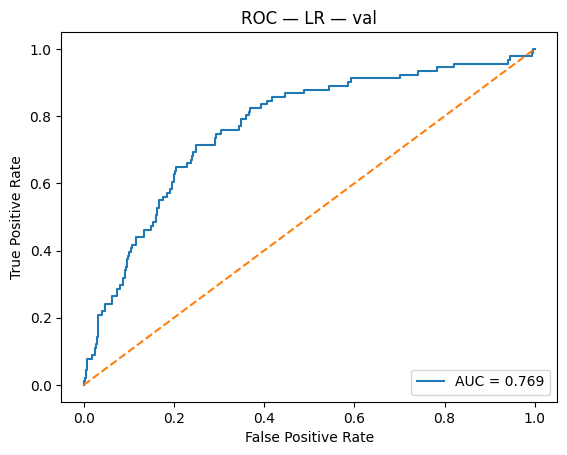


=== RF — val ===
Accuracy : 0.8983
F1 (macro / weighted): 0.5499 / 0.8718
AUC-ROC : 0.7124

Per-class metrics:
              precision    recall  f1-score   support

      class0     0.9134    0.9807    0.9459       882
      class1     0.3462    0.0989    0.1538        91

    accuracy                         0.8983       973
   macro avg     0.6298    0.5398    0.5499       973
weighted avg     0.8604    0.8983    0.8718       973

Confusion matrix:


,pred_class0,pred_class1
true_class0,865,17
true_class1,82,9


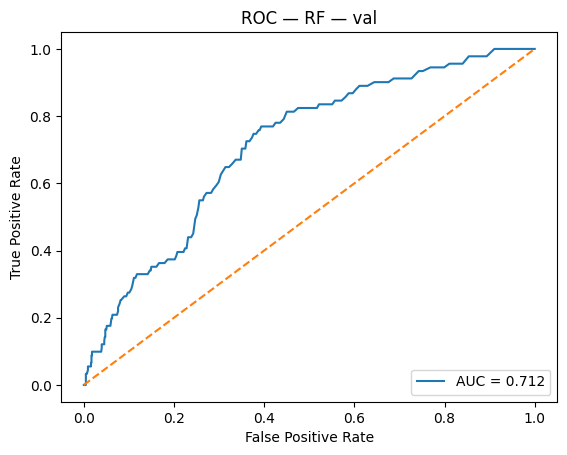


=== XGB — val ===
Accuracy : 0.8849
F1 (macro / weighted): 0.5248 / 0.8611
AUC-ROC : 0.7085

Per-class metrics:
              precision    recall  f1-score   support

      class0     0.9104    0.9683    0.9385       882
      class1     0.2000    0.0769    0.1111        91

    accuracy                         0.8849       973
   macro avg     0.5552    0.5226    0.5248       973
weighted avg     0.8440    0.8849    0.8611       973

Confusion matrix:


,pred_class0,pred_class1
true_class0,854,28
true_class1,84,7


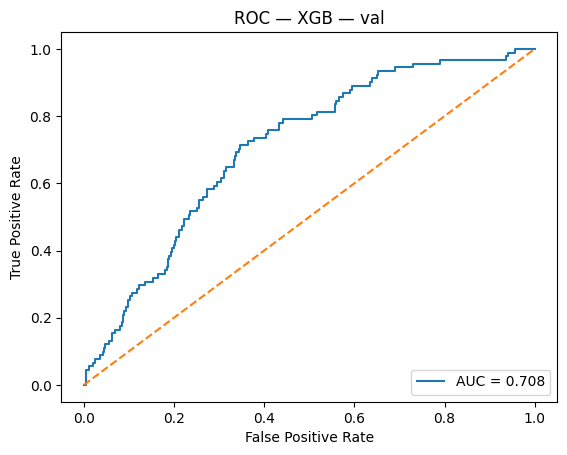


=== MLP — val ===
Accuracy : 0.8736
F1 (macro / weighted): 0.5417 / 0.8588
AUC-ROC : 0.6987

Per-class metrics:
              precision    recall  f1-score   support

      class0     0.9129    0.9512    0.9317       882
      class1     0.2037    0.1209    0.1517        91

    accuracy                         0.8736       973
   macro avg     0.5583    0.5361    0.5417       973
weighted avg     0.8466    0.8736    0.8588       973

Confusion matrix:


,pred_class0,pred_class1
true_class0,839,43
true_class1,80,11


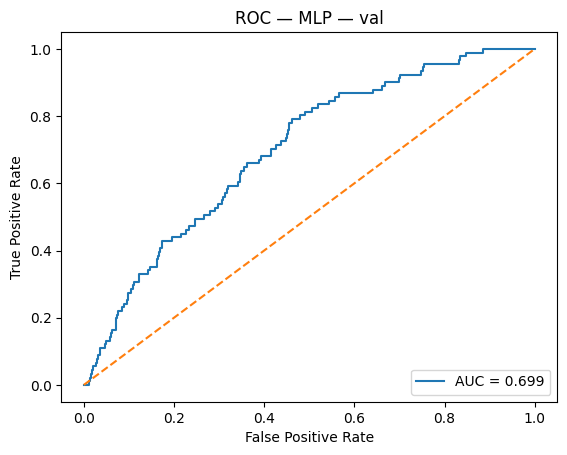


=== TabNet — val ===
Accuracy : 0.4604
F1 (macro / weighted): 0.4012 / 0.5543
AUC-ROC : 0.6184

Per-class metrics:
              precision    recall  f1-score   support

      class0     0.9496    0.4274    0.5895       882
      class1     0.1233    0.7802    0.2129        91

    accuracy                         0.4604       973
   macro avg     0.5364    0.6038    0.4012       973
weighted avg     0.8723    0.4604    0.5543       973

Confusion matrix:


,pred_class0,pred_class1
true_class0,377,505
true_class1,20,71


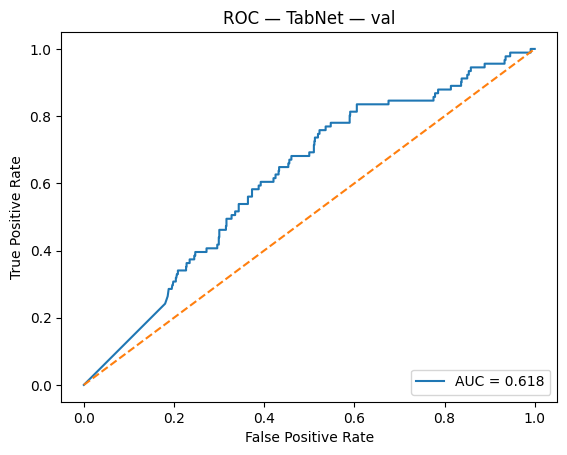

In [13]:
# Binary example with your setup
evaluate_classifier(models["lr"],     X_val_scaled, y_val, class_names=["class0","class1"], title="LR — val")
evaluate_classifier(models["rf"],     X_val,        y_val, class_names=["class0","class1"], title="RF — val")
evaluate_classifier(models["xgb"],    X_val,        y_val, class_names=["class0","class1"], title="XGB — val")
evaluate_classifier(models["mlp"],    X_val_scaled, y_val, class_names=["class0","class1"], title="MLP — val")

# Only TabNet needs array input
# evaluate_classifier(models["tabnet"], X_val,        y_val, class_names=["class0","class1"], title="TabNet — val")
evaluate_classifier(models["tabnet"], X_val.values, y_val, class_names=["class0","class1"], title="TabNet — val")



In [14]:
# ============================================================
# 6) Test metrics
# ============================================================
def proba_np(model, X):
    if isinstance(model, (TabNetClassifier)):
        return model.predict_proba(X.values if isinstance(X, pd.DataFrame) else X)
    return model.predict_proba(X)

with Timer("Test-set metrics"):
    test_metrics = {
        "lr":     perf_summary(y_test.values, proba_np(lr,     X_test_scaled)[:,1]),
        "rf":     perf_summary(y_test.values, proba_np(rf,     X_test)[:,1]),
        "xgb":    perf_summary(y_test.values, proba_np(xgb,    X_test)[:,1]),
        "mlp":    perf_summary(y_test.values, proba_np(mlp,    X_test_scaled)[:,1]),
        "tabnet": perf_summary(y_test.values, proba_np(tn,     X_test)[:,1]),
    }
    test_df = pd.DataFrame(test_metrics).T[["roc_auc","pr_auc","ece"]]
    print(test_df.round(4))


[23:14:31] START: Test-set metrics
        roc_auc  pr_auc     ece
lr       0.8002  0.3152  0.0496
rf       0.7737  0.2678  0.0623
xgb      0.7563  0.2849  0.0562
mlp      0.7420  0.2464  0.0695
tabnet   0.5921  0.1117  0.3718
[23:14:32] END:   Test-set metrics  (took 0.39s)



### SHAP Analysis

In [25]:
# ============================================================
# 4) SHAP
# ============================================================
def compute_default_shap(imp_mag_default={}, imp_signed_default={}):

    with Timer("SHAP: Linear (LR) + Tree (RF, XGB)"):
        bg_idx_lin  = sub_idx(len(X_train_res_scaled), LIN_BG_MAX)
        ev_idx_lin  = sub_idx(len(X_val_scaled),      LIN_EV_MAX)
        bg_idx_tr   = sub_idx(len(X_train_res), TREE_BG_MAX)
        ev_idx_tr   = sub_idx(len(X_val),      TREE_EV_MAX)
    
        if "lr" in use_models:
            stamp(f"[LR] Linear SHAP on scaled: bg={len(bg_idx_lin)}, eval={len(ev_idx_lin)}")
            imp_mag_default["lr"]    = linear_shap_lr(lr, X_train_res_scaled.iloc[bg_idx_lin], X_val_scaled.iloc[ev_idx_lin], feat_names, signed=False)
            imp_signed_default["lr"] = linear_shap_lr(lr, X_train_res_scaled.iloc[bg_idx_lin], X_val_scaled.iloc[ev_idx_lin], feat_names, signed=True)
    
        if "rf" in use_models:
            stamp(f"[RF] Tree SHAP on unscaled: bg={len(bg_idx_tr)}, eval={len(ev_idx_tr)}")
            imp_mag_default["rf"]    = tree_shap(rf,  X_train_res.iloc[bg_idx_tr], X_val.iloc[ev_idx_tr], feat_names, signed=False)
            imp_signed_default["rf"] = tree_shap(rf,  X_train_res.iloc[bg_idx_tr], X_val.iloc[ev_idx_tr], feat_names, signed=True)
    
        if "xgb" in use_models:
            stamp(f"[XGB] Tree SHAP on unscaled: bg={len(bg_idx_tr)}, eval={len(ev_idx_tr)}")
            imp_mag_default["xgb"]    = tree_shap(xgb, X_train_res.iloc[bg_idx_tr], X_val.iloc[ev_idx_tr], feat_names, signed=False)
            imp_signed_default["xgb"] = tree_shap(xgb, X_train_res.iloc[bg_idx_tr], X_val.iloc[ev_idx_tr], feat_names, signed=True)
    
    def explain_blackbox_fast(name, predict_proba_fn, X_bg_df, X_ev_df, feat_names, signed=False):
        X_bg_np = kmeans_background(X_bg_df.values, k=HEAVY_BG_K, random_state=RANDOM_STATE)
        n_eval = min(HEAVY_EV_K, len(X_ev_df))
        X_ev_np = X_ev_df.sample(n=n_eval, random_state=RANDOM_STATE).values if len(X_ev_df) > n_eval else X_ev_df.values
        stamp(f"[{name}] SHAP ({'Permutation' if SHAP_BACKEND!='kernel' else 'Kernel'}) with kmeans-bg={HEAVY_BG_K}, eval={n_eval}")
        if SHAP_BACKEND == "kernel":
            return kernel_shap_from_proba(predict_proba_fn, X_bg_np, X_ev_np, feat_names, signed=signed)
        else:
            return perm_shap_from_proba(predict_proba_fn, X_bg_np, X_ev_np, feat_names, signed=signed)
    
    with Timer("SHAP: Heavy models (MLP, TabNet)"):
        if "mlp" in use_models:
            imp_mag_default["mlp"]    = explain_blackbox_fast("MLP",    lambda Z: mlp.predict_proba(Z), X_train_res_scaled, X_val_scaled, feat_names, signed=False)
            imp_signed_default["mlp"] = explain_blackbox_fast("MLP",    lambda Z: mlp.predict_proba(Z), X_train_res_scaled, X_val_scaled, feat_names, signed=True)
        if "tabnet" in use_models:
            imp_mag_default["tabnet"]    = explain_blackbox_fast("TabNet", lambda Z: tn.predict_proba(Z), X_train_res, X_val, feat_names, signed=False)
            imp_signed_default["tabnet"] = explain_blackbox_fast("TabNet", lambda Z: tn.predict_proba(Z), X_train_res, X_val, feat_names, signed=True)
    
    return imp_mag_default, imp_signed_default

# UNCOMMENT FOLLOWING LINES TO RUN DEFAULT SHAP
imp_mag_default, imp_signed_default = {}, {}
# imp_mag_default, imp_signed_default  = compute_default_shap(imp_mag_default, imp_signed_default )


### Permutation SHAP

In [15]:
import numpy as np
import pandas as pd
import shap
import inspect

def _to_numpy(x):
    # Unwrap SHAP DenseData or similar wrappers to raw numpy
    if hasattr(x, "data"):      # DenseData has .data
        return np.asarray(x.data)
    return np.asarray(x)

def permutation_shap_proba(
    model,
    X_bg_df,
    X_ev_df,
    feature_names=None,
    n_bg=32,
    n_eval=64,
    random_state=0,
    class_index="auto",   # "auto" -> 1 for binary else 0
    aggregate="mean_abs", # "mean_abs" | "sum_abs"
):
    rng = np.random.default_rng(random_state)

    # --- arrays ---
    X_bg_np = _to_numpy(X_bg_df.values if hasattr(X_bg_df, "values") else X_bg_df)
    X_ev_np = _to_numpy(X_ev_df.values if hasattr(X_ev_df, "values") else X_ev_df)

    # --- k-means background (may return DenseData in older SHAP) ---
    try:
        bg = shap.kmeans(X_bg_np, k=min(n_bg, len(X_bg_np)), random_state=random_state)
    except TypeError:
        bg = shap.kmeans(X_bg_np, k=min(n_bg, len(X_bg_np)))
    X_bg_np = _to_numpy(bg)  # <-- unwrap DenseData to np array

    # --- subsample eval ---
    if len(X_ev_np) > n_eval:
        idx = rng.choice(len(X_ev_np), size=n_eval, replace=False)
        X_ev_np = X_ev_np[idx]

    # --- feature names ---
    if feature_names is None:
        if hasattr(X_bg_df, "columns"):
            feature_names = list(X_bg_df.columns)
        else:
            feature_names = [f"f{i}" for i in range(X_bg_np.shape[1])]

    # --- callable masker (must receive numpy, not DenseData) ---
    callable_masker = shap.maskers.Independent(X_bg_np)

    # --- construct explainer (prefer modern APIs) ---
    explainer = None
    errors = []

    try:
        explainer = shap.Explainer(model.predict_proba, callable_masker, algorithm="permutation")
    except Exception as e:
        errors.append(f"Explainer(permutation) -> {type(e).__name__}: {e}")

    if explainer is None:
        try:
            explainer = shap.explainers.Permutation(model.predict_proba, masker=callable_masker, feature_names=feature_names)
        except Exception as e:
            errors.append(f"Permutation(masker=) -> {type(e).__name__}: {e}")

    if explainer is None:
        try:
            sig = inspect.signature(shap.PermutationExplainer.__init__)
            if "masker" in sig.parameters:
                explainer = shap.PermutationExplainer(model.predict_proba, masker=callable_masker, feature_names=feature_names)
            else:
                raise RuntimeError("PermutationExplainer lacks 'masker' in this SHAP version; skip DenseData path.")
        except Exception as e:
            errors.append(f"Legacy PermutationExplainer(masker=) -> {type(e).__name__}: {e}")

    if explainer is None:
        raise RuntimeError("Could not construct a permutation explainer:\n- " + "\n- ".join(errors))

    # --- compute SHAP with modern call path (returns Explanation) ---
    sv = explainer(X_ev_np)
    values = sv.values
    base_values = sv.base_values

    # normalize shapes to (n_eval, n_feat, n_classes)
    if values.ndim == 2:
        values = values[:, :, None]
        if base_values.ndim == 1:
            base_values = base_values[:, None]

    n_eval, n_feat, n_classes = values.shape
    if class_index == "auto":
        cls_idx = 1 if n_classes == 2 else 0
    else:
        cls_idx = int(class_index)
        if not (0 <= cls_idx < n_classes):
            raise ValueError(f"class_index {cls_idx} out of range [0, {n_classes-1}]")

    if aggregate == "mean_abs":
        agg_abs = np.mean(np.abs(values[:, :, cls_idx]), axis=0)
        agg_signed = np.mean(values[:, :, cls_idx], axis=0)
    elif aggregate == "sum_abs":
        agg_abs = np.sum(np.abs(values[:, :, cls_idx]), axis=0)
        agg_signed = np.sum(values[:, :, cls_idx], axis=0)
    else:
        raise ValueError("aggregate must be 'mean_abs' or 'sum_abs'")

    abs_s = pd.Series(agg_abs, index=feature_names, name="shap_abs")
    signed_s = pd.Series(agg_signed, index=feature_names, name="shap_signed")
    denom = abs_s.abs().sum()
    norm_s = (abs_s.abs() / denom) if denom and pd.notna(denom) else abs_s.abs()
    norm_s.name = "shap_norm"

    meta = {
        "n_eval": int(n_eval),
        "n_bg": int(len(X_bg_np)),
        "n_classes": int(n_classes),
        "class_index": int(cls_idx),
    }
    return {"abs": abs_s, "signed": signed_s, "norm": norm_s, "meta": meta}


In [18]:
# --- 1) Compute permutation SHAP for your black-box models ---

def compute_permutation_shap(imp_mag_permuta = {}, imp_signed_permuta = {}):
    
    # --- Permutation SHAP for LR, RF, XGB, MLP, TabNet (model-agnostic, probability space) ---
    # LR (trained on *scaled* data)
    res_lr = permutation_shap_proba(
        model=lr,
        X_bg_df=X_train_res_scaled,
        X_ev_df=X_val_scaled,
        feature_names=list(X_train_res_scaled.columns),
        n_bg=32, n_eval=64, random_state=RANDOM_STATE, class_index="auto"
    )
    imp_mag_permuta["lr"]    = res_lr["abs"]
    imp_signed_permuta["lr"] = res_lr["signed"]
    
    # RF (trained on *unscaled* data)
    res_rf = permutation_shap_proba(
        model=rf,
        X_bg_df=X_train_res,
        X_ev_df=X_val,
        feature_names=list(X_train_res.columns),
        n_bg=32, n_eval=64, random_state=RANDOM_STATE, class_index="auto"
    )
    imp_mag_permuta["rf"]    = res_rf["abs"]
    imp_signed_permuta["rf"] = res_rf["signed"]
    
    # XGB (trained on *unscaled* data)
    # Make sure xgb.predict_proba returns probabilities (it does for XGBClassifier)
    res_xgb = permutation_shap_proba(
        model=xgb,
        X_bg_df=X_train_res,
        X_ev_df=X_val,
        feature_names=list(X_train_res.columns),
        n_bg=32, n_eval=64, random_state=RANDOM_STATE, class_index="auto"
    )
    imp_mag_permuta["xgb"]    = res_xgb["abs"]
    imp_signed_permuta["xgb"] = res_xgb["signed"]
    
    
    # For MLP (trained on *scaled* data)
    res_mlp = permutation_shap_proba(
        model=mlp,
        X_bg_df=X_train_res_scaled,
        X_ev_df=X_val_scaled,
        feature_names=list(X_train_res_scaled.columns),
        n_bg=32,          # k-means background size
        n_eval=64,        # eval subsample size
        random_state=RANDOM_STATE,
        class_index="auto",   # or 1 for binary positive class
        aggregate="mean_abs"  # or "sum_abs"
    )
    imp_mag_permuta["mlp"]    = res_mlp["abs"]     # |SHAP|
    imp_signed_permuta["mlp"] = res_mlp["signed"]  # signed SHAP
    
    # For TabNet (trained on *unscaled* data)
    res_tn = permutation_shap_proba(
        model=tn,
        X_bg_df=X_train_res,
        X_ev_df=X_val,
        feature_names=list(X_train_res.columns),
        n_bg=32, n_eval=64, random_state=RANDOM_STATE, class_index="auto"
    )
    imp_mag_permuta["tabnet"]    = res_tn["abs"]
    imp_signed_permuta["tabnet"] = res_tn["signed"]
    
    # (Optional) You can inspect details like:
    # print(res_mlp["meta"], res_tn["meta"])

    return imp_mag_permuta, imp_signed_permuta


imp_mag_permuta, imp_signed_permuta = {}, {}
imp_mag_permuta, imp_signed_permuta = compute_permutation_shap(imp_mag_permuta, imp_signed_permuta)

PermutationExplainer explainer: 65it [03:57,  3.83s/it]                                                                                                                                                                                      
PermutationExplainer explainer: 65it [00:19,  1.58it/s]                                                                                                                                                                                      


In [19]:
# --- 2) Build the feature table with columns: abs, value, norm (per model) ---

import pandas as pd

model_order = ["lr", "rf", "xgb", "mlp", "tabnet"]  # include only what you computed
models = [m for m in model_order if (m in imp_mag_permuta) and (m in imp_signed_permuta)]

def _as_series(x):
    if isinstance(x, pd.Series): return x
    if isinstance(x, pd.DataFrame):
        num_cols = [c for c in x.columns if pd.api.types.is_numeric_dtype(x[c])]
        return x[num_cols[0]]
    raise TypeError(f"Unexpected importance type: {type(x)}")

frames = []
for m in models:
    mag = _as_series(imp_mag_permuta[m])      # |SHAP|
    sgn = _as_series(imp_signed_permuta[m])   # signed SHAP
    mag, sgn = mag.align(sgn, join="outer")
    denom = mag.abs().sum()
    norm = mag.abs() / denom if denom and pd.notna(denom) else mag.abs()
    frames.append(pd.DataFrame({
        f"{m} (shap abs)":   mag.abs(),
        f"{m} (shap value)": sgn,
        f"{m} (shap norm)":  norm
    }))

feat_tbl = pd.concat(frames, axis=1)
feat_tbl = feat_tbl.rename_axis("feature").reset_index()

# (Optional) sort rows by average normalized importance across models
norm_cols = [c for c in feat_tbl.columns if c.endswith("(shap norm)")]
feat_tbl["avg_norm"] = feat_tbl[norm_cols].mean(axis=1, skipna=True)
feat_tbl = feat_tbl.sort_values("avg_norm", ascending=False).drop(columns=["avg_norm"])

feat_tbl.head(30)


,feature,lr (shap abs),lr (shap value),lr (shap norm),rf (shap abs),rf (shap value),rf (shap norm),xgb (shap abs),xgb (shap value),xgb (shap norm),mlp (shap abs),mlp (shap value),mlp (shap norm),tabnet (shap abs),tabnet (shap value),tabnet (shap norm)
17,GeneralHealth_Good,0.221250,-0.154233,0.164542,0.149328,-0.142791,0.177191,0.225849,-0.217028,0.201475,0.222290,-0.156513,0.158212,0.108721,0.099243,0.128571
22,smokeStat_Never,0.240802,-0.114837,0.179083,0.155759,-0.092628,0.184822,0.184946,-0.115910,0.164986,0.226115,-0.104528,0.160934,0.017139,0.004571,0.020268
16,GeneralHealth_VeryGood,0.169217,-0.064014,0.125846,0.115039,-0.087146,0.136504,0.155919,-0.115824,0.139092,0.170464,-0.062963,0.121325,0.040886,0.014948,0.048351
9,Age,0.051673,-0.001041,0.038429,0.078426,0.006948,0.093059,0.072152,0.014422,0.064365,0.053865,0.008268,0.038338,0.121993,0.014570,0.144267
21,smokeStat_Former,0.129642,-0.065786,0.096414,0.063539,-0.056369,0.075395,0.091521,-0.083112,0.081644,0.116845,-0.057705,0.083163,0.009016,-0.004802,0.010662
20,smokeStat_Current,0.078413,-0.008846,0.058316,0.035705,-0.027062,0.042368,0.049284,-0.032510,0.043965,0.077888,-0.010996,0.055436,0.007826,-0.001825,0.009254
18,GeneralHealth_Fair,0.066601,-0.045346,0.049531,0.028004,-0.023770,0.033230,0.064197,-0.049696,0.057268,0.068979,-0.049971,0.049095,0.006216,-0.003913,0.007351
25,eCigUse_Never,0.113653,-0.044072,0.084523,0.004953,-0.002002,0.005878,0.014853,-0.002965,0.013250,0.099316,-0.036728,0.070687,0.010842,0.001451,0.012821
15,GeneralHealth_Excellent,0.067884,-0.011057,0.050485,0.032777,-0.032777,0.038892,0.047252,-0.047252,0.042152,0.067222,-0.007494,0.047844,0.004509,-0.003159,0.005332
0,FreqGoProvider,0.010920,-0.000526,0.008121,0.016875,-0.004809,0.020024,0.022042,-0.005073,0.019663,0.016378,-0.004611,0.011657,0.101333,0.037757,0.119835


In [20]:
# --- 3) Export the table (CSV + Excel + Parquet optional) ---

with Timer("Exporting the SHAP values csv file"):
    
    from datetime import datetime
    from pathlib import Path
    
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_csv  = f"shap_feature_table_{ts}.csv"
    # Ensure the directory exists
    out_dir = Path("op/shap_analy")
    out_dir.mkdir(parents=True, exist_ok=True)
    
    # Choose a filename (timestamped to avoid overwrites)
    out_csv = out_dir / f"shap_feature_table_permutation_{ts}.csv"
    
    # Save the table
    feat_tbl.to_csv(out_csv, index=False)
    
    print(f"Saved CSV to: {out_csv}")



[23:39:55] START: Exporting the SHAP values csv file
Saved CSV to: op/shap_analy/shap_feature_table_permutation_20251007_233955.csv
[23:39:55] END:   Exporting the SHAP values csv file  (took 0.01s)



#### Kernel SHAP

In [22]:
# --- Robust Kernel SHAP for predict_proba (model-agnostic) -------------------
import numpy as np
import pandas as pd
import shap
import inspect

def _to_numpy(x):
    # Unwrap SHAP DenseData or similar wrappers to raw numpy
    if hasattr(x, "data"):  # DenseData has .data
        return np.asarray(x.data)
    return np.asarray(x)

def kernel_shap_proba(
    model,
    X_bg_df,
    X_ev_df,
    feature_names=None,
    n_bg=32,
    n_eval=64,
    random_state=0,
    class_index="auto",    # "auto" -> 1 for binary else 0, or pass an int
    link="identity",       # "identity" or "logit"
    nsamples="auto",       # controls runtime; int or "auto"
    aggregate="mean_abs",  # "mean_abs" | "sum_abs"
):
    """
    Kernel SHAP on model.predict_proba for a single class (chosen via class_index).
    Returns dict: {"abs": Series, "signed": Series, "norm": Series, "meta": {...}}
    """
    rng = np.random.default_rng(random_state)

    # --- arrays + optional subsampling ---
    X_bg_np = _to_numpy(X_bg_df.values if hasattr(X_bg_df, "values") else X_bg_df)
    X_ev_np = _to_numpy(X_ev_df.values if hasattr(X_ev_df, "values") else X_ev_df)

    # Summarize background via k-means (unwrap DenseData if returned)
    try:
        bg = shap.kmeans(X_bg_np, k=min(n_bg, len(X_bg_np)), random_state=random_state)
    except TypeError:
        bg = shap.kmeans(X_bg_np, k=min(n_bg, len(X_bg_np)))
    X_bg_np = _to_numpy(bg)

    if len(X_ev_np) > n_eval:
        idx = rng.choice(len(X_ev_np), size=n_eval, replace=False)
        X_ev_np = X_ev_np[idx]

    # Feature names
    if feature_names is None:
        if hasattr(X_bg_df, "columns"):
            feature_names = list(X_bg_df.columns)
        else:
            feature_names = [f"f{i}" for i in range(X_bg_np.shape[1])]

    # --- determine class index from a probe call ---
    proba_probe = model.predict_proba(X_ev_np[: min(8, len(X_ev_np))])
    if proba_probe.ndim == 1:
        proba_probe = proba_probe[:, None]
    n_classes = proba_probe.shape[1]
    if class_index == "auto":
        cls_idx = 1 if n_classes == 2 else 0
    else:
        cls_idx = int(class_index)
        if not (0 <= cls_idx < n_classes):
            raise ValueError(f"class_index {cls_idx} out of range [0, {n_classes-1}]")

    # Wrap predict_proba to scalar output (KernelExplainer prefers scalar f)
    def f_cls(Z):
        p = model.predict_proba(Z)
        if p.ndim == 1:
            return p  # already scalar per row
        return p[:, cls_idx]

    # Link
    if link == "identity":
        link_obj = getattr(shap.links, "identity", shap.links.identity)
    elif link == "logit":
        link_obj = getattr(shap.links, "logit", shap.links.logit)
    else:
        raise ValueError("link must be 'identity' or 'logit'")

    # --- Build explainer (prefer modern APIs) ---
    explainer = None
    errs = []

    # A) Unified API
    try:
        masker = shap.maskers.Independent(X_bg_np)
        explainer = shap.Explainer(f_cls, masker, algorithm="kernel", link=link_obj)
    except Exception as e:
        errs.append(f"Explainer(kernel) -> {type(e).__name__}: {e}")

    # B) New-style Kernel explainer
    if explainer is None:
        try:
            masker = shap.maskers.Independent(X_bg_np)
            explainer = shap.explainers.Kernel(f_cls, masker=masker, link=link_obj)
        except Exception as e:
            errs.append(f"explainers.Kernel(masker=) -> {type(e).__name__}: {e}")

    # C) Legacy KernelExplainer(data=bg)
    if explainer is None:
        try:
            # Legacy expects data array, not masker
            explainer = shap.KernelExplainer(f_cls, X_bg_np, link=link)
        except Exception as e:
            errs.append(f"KernelExplainer(data) -> {type(e).__name__}: {e}")

    if explainer is None:
        raise RuntimeError("Could not construct Kernel explainer:\n- " + "\n- ".join(errs))

    # --- Compute SHAP values (handle both new/old call signatures) ---
    values = None
    base_value = None
    call_errs = []

    # Style 1: new API -> Explanation via explainer(X, max_evals=...)
    try:
        kwargs = {}
        if nsamples != "auto":
            # In new API, 'nsamples' ~ 'max_evals'
            kwargs["max_evals"] = int(nsamples)
        sv = explainer(X_ev_np, **kwargs)
        # Explanation for scalar f -> (n_eval, n_feat)
        values = sv.values
        # base_values is (n_eval,) for scalar output
        base_value = np.mean(np.atleast_1d(sv.base_values))
    except Exception as e:
        call_errs.append(f"call_new:{type(e).__name__}: {e}")

    # Style 2: legacy -> explainer.shap_values(X, nsamples=...)
    if values is None:
        try:
            kwargs = {}
            if nsamples != "auto":
                kwargs["nsamples"] = int(nsamples)
            shap_vals = explainer.shap_values(X_ev_np, **kwargs)  # (n_eval, n_feat)
            values = np.asarray(shap_vals)
            # expected_value may be scalar or array; we just store mean for meta
            ev = getattr(explainer, "expected_value", 0.0)
            base_value = float(np.mean(np.atleast_1d(ev)))
        except Exception as e:
            call_errs.append(f"call_legacy:{type(e).__name__}: {e}")

    if values is None:
        raise RuntimeError("Failed to compute Kernel SHAP via both call styles:\n- " + "\n- ".join(call_errs))

    # --- Aggregate across eval samples ---
    if aggregate == "mean_abs":
        agg_abs = np.mean(np.abs(values), axis=0)
        agg_signed = np.mean(values, axis=0)
    elif aggregate == "sum_abs":
        agg_abs = np.sum(np.abs(values), axis=0)
        agg_signed = np.sum(values, axis=0)
    else:
        raise ValueError("aggregate must be 'mean_abs' or 'sum_abs'")

    abs_s = pd.Series(agg_abs, index=feature_names, name="shap_abs")
    signed_s = pd.Series(agg_signed, index=feature_names, name="shap_signed")
    denom = abs_s.abs().sum()
    norm_s = (abs_s.abs() / denom) if denom and pd.notna(denom) else abs_s.abs()
    norm_s.name = "shap_norm"

    meta = {
        "n_eval": int(values.shape[0]),
        "n_bg": int(len(X_bg_np)),
        "n_classes": int(n_classes),
        "class_index": int(cls_idx),
        "link": link,
        "nsamples": nsamples,
        "base_value_mean": float(base_value),
    }
    return {"abs": abs_s, "signed": signed_s, "norm": norm_s, "meta": meta}


In [23]:

def compute_kernel_shap(imp_mag_kernel={}, imp_signed_kernel={}):

    # === LR on *scaled* data ===
    res_lr_k = kernel_shap_proba(
        model=lr,
        X_bg_df=X_train_res_scaled,
        X_ev_df=X_val_scaled,
        feature_names=list(X_train_res_scaled.columns),
        n_bg=32,
        n_eval=64,
        random_state=RANDOM_STATE,
        class_index="auto",
        link="identity",
        nsamples="auto"        # e.g., 2000 for tighter estimates
    )
    imp_mag_kernel["lr"]    = res_lr_k["abs"]
    imp_signed_kernel["lr"] = res_lr_k["signed"]
    
    # === RF on *unscaled* data ===
    res_rf_k = kernel_shap_proba(
        model=rf,
        X_bg_df=X_train_res,
        X_ev_df=X_val,
        feature_names=list(X_train_res.columns),
        n_bg=32,
        n_eval=64,
        random_state=RANDOM_STATE,
        class_index="auto",
        link="identity",
        nsamples="auto"
    )
    imp_mag_kernel["rf"]    = res_rf_k["abs"]
    imp_signed_kernel["rf"] = res_rf_k["signed"]
    
    # === XGBoost on *unscaled* data ===
    res_xgb_k = kernel_shap_proba(
        model=xgb,
        X_bg_df=X_train_res,
        X_ev_df=X_val,
        feature_names=list(X_train_res.columns),
        n_bg=32,
        n_eval=64,
        random_state=RANDOM_STATE,
        class_index="auto",
        link="identity",
        nsamples="auto"
    )
    imp_mag_kernel["xgb"]    = res_xgb_k["abs"]
    imp_signed_kernel["xgb"] = res_xgb_k["signed"]
    
    # MLP on *scaled* data (probability space)
    res_mlp_k = kernel_shap_proba(
        model=mlp,
        X_bg_df=X_train_res_scaled,
        X_ev_df=X_val_scaled,
        feature_names=list(X_train_res_scaled.columns),
        n_bg=32,
        n_eval=64,
        random_state=RANDOM_STATE,
        class_index="auto",  # or set 1 for positive class
        link="identity",     # try "logit" for log-odds if you prefer
        nsamples="auto"      # or an int like 2_000 for tighter estimates
    )
    imp_mag_kernel["mlp"]    = res_mlp_k["abs"]
    imp_signed_permuta["mlp"] = res_mlp_k["signed"]
    
    # TabNet on *unscaled* data
    res_tn_k = kernel_shap_proba(
        model=tn,
        X_bg_df=X_train_res,
        X_ev_df=X_val,
        feature_names=list(X_train_res.columns),
        n_bg=32, n_eval=64, random_state=RANDOM_STATE, class_index="auto",
        link="identity", nsamples="auto"
    )
    imp_mag_kernel["tabnet"]    = res_tn_k["abs"]
    imp_signed_permuta["tabnet"] = res_tn_k["signed"]

    return imp_mag_kernel, imp_signed_kernel


imp_mag_kernel, imp_signed_kernel = {}, {}
imp_mag_kernel, imp_signed_kernel = compute_kernel_shap(imp_mag_kernel, imp_signed_kernel)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [01:32<00:00,  1.45s/it]


In [24]:
# === Build + display pretty + export Kernel SHAP feature table ===
import pandas as pd
from pathlib import Path
from datetime import datetime
from IPython.display import display  # pretty HTML display in notebooks

# 1) Choose models to include (only those present in imp_mag_kernel/imp_signed_permuta will be used)
model_order = ["lr", "rf", "xgb", "mlp", "tabnet"]  # adjust if you want only kernel-based models
models = [m for m in model_order if (m in imp_mag_kernel) and (m in imp_signed_permuta)]

def _as_series(x):
    if isinstance(x, pd.Series): return x
    if isinstance(x, pd.DataFrame):
        num_cols = [c for c in x.columns if pd.api.types.is_numeric_dtype(x[c])]
        return x[num_cols[0]]
    return pd.Series(x)

# 2) Build per-model columns: abs, signed, normalized
frames = []
for m in models:
    mag = _as_series(imp_mag_kernel[m])      # |SHAP| (from Kernel SHAP or other)
    sgn = _as_series(imp_signed_permuta[m])   # signed SHAP
    mag, sgn = mag.align(sgn, join="outer")
    denom = mag.abs().sum()
    norm = (mag.abs() / denom) if denom and pd.notna(denom) else mag.abs()
    frames.append(pd.DataFrame({
        f"{m} (shap abs)":   mag.abs(),
        f"{m} (shap value)": sgn,
        f"{m} (shap norm)":  norm
    }))

feat_tbl = pd.concat(frames, axis=1)
feat_tbl = feat_tbl.rename_axis("feature").reset_index()

# 3) Optional: sort rows by average normalized importance across included models
norm_cols = [c for c in feat_tbl.columns if c.endswith("(shap norm)")]
feat_tbl["avg_norm"] = feat_tbl[norm_cols].mean(axis=1, skipna=True)
feat_tbl = feat_tbl.sort_values("avg_norm", ascending=False).drop(columns=["avg_norm"])

# 4) Pretty display (HTML table, like your screenshot)
#    (no jinja2 / Styler needed)
display(feat_tbl.head(30))

# 5) Export to CSV inside op/shap_analy/ (create if missing)
out_dir = Path("op/shap_analy")
out_dir.mkdir(parents=True, exist_ok=True)
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
out_csv = out_dir / f"shap_feature_table_kernel_{ts}.csv"
feat_tbl.to_csv(out_csv, index=False)
print(f"\nSaved CSV to: {out_csv}")


,feature,lr (shap abs),lr (shap value),lr (shap norm),rf (shap abs),rf (shap value),rf (shap norm),xgb (shap abs),xgb (shap value),xgb (shap norm),mlp (shap abs),mlp (shap value),mlp (shap norm),tabnet (shap abs),tabnet (shap value),tabnet (shap norm)
17,GeneralHealth_Good,0.221426,-0.154233,0.180156,0.147164,-0.142791,0.186505,0.222800,-0.217028,0.213211,0.218193,-0.152767,0.178643,0.109262,0.104705,0.144748
22,smokeStat_Never,0.239697,-0.114837,0.195022,0.156320,-0.092628,0.198109,0.181951,-0.115910,0.174120,0.221235,-0.103809,0.181134,0.010277,0.002631,0.013615
16,GeneralHealth_VeryGood,0.169328,-0.064014,0.137769,0.113037,-0.087146,0.143255,0.157588,-0.115824,0.150805,0.168522,-0.061858,0.137976,0.032332,0.020878,0.042832
9,Age,0.047307,-0.001041,0.038490,0.075610,0.006948,0.095823,0.068949,0.014422,0.065981,0.047114,0.012512,0.038574,0.116577,0.013057,0.154439
21,smokeStat_Former,0.131930,-0.065786,0.107341,0.060121,-0.056369,0.076193,0.088964,-0.083112,0.085135,0.116281,-0.057329,0.095203,0.006325,-0.005039,0.008380
20,smokeStat_Current,0.076880,-0.008846,0.062551,0.031409,-0.027062,0.039805,0.043077,-0.032510,0.041223,0.076027,-0.009917,0.062247,0.004721,-0.002160,0.006254
15,GeneralHealth_Excellent,0.069578,-0.011057,0.056610,0.032547,-0.032777,0.041248,0.047157,-0.047252,0.045127,0.065143,-0.009933,0.053335,0.004729,-0.003159,0.006265
18,GeneralHealth_Fair,0.055616,-0.045346,0.045250,0.025780,-0.023770,0.032672,0.057011,-0.049696,0.054557,0.057270,-0.056857,0.046889,0.003208,-0.001812,0.004249
25,eCigUse_Never,0.110364,-0.044072,0.089794,0.000586,-0.002002,0.000742,0.007745,-0.002965,0.007411,0.088333,-0.030167,0.072321,0.007046,-0.003713,0.009334
0,FreqGoProvider,0.002145,-0.000526,0.001745,0.013762,-0.004809,0.017441,0.017900,-0.005073,0.017130,0.005875,-0.003411,0.004810,0.097111,0.039751,0.128651



Saved CSV to: op/shap_analy/shap_feature_table_kernel_20251007_234851.csv


In [31]:
# ============================================================
# 7) Exports
# ============================================================
with Timer("Export artifacts"):
    pd.DataFrame(imp_mag).to_csv(os.path.join(OUTDIR, "per_model_mean_abs_shap.csv"))
    pd.DataFrame(imp_signed).to_csv(os.path.join(OUTDIR, "per_model_mean_signed_shap.csv"))
    comp_df.to_csv(os.path.join(OUTDIR, "composite_importance.csv"))
    perf_df.to_csv(os.path.join(OUTDIR, "validation_metrics_for_weights.csv"))
    w_series.to_csv(os.path.join(OUTDIR, "model_weights.csv"))
    test_df.to_csv(os.path.join(OUTDIR, "test_metrics.csv"))

    def plot_topn(series, title, outpath, topn=20):
        s = series.sort_values(ascending=False).head(topn)[::-1]
        plt.figure(figsize=(8, max(4, topn*0.35))); plt.barh(s.index, s.values)
        plt.title(title); plt.tight_layout(); plt.savefig(outpath, dpi=150); plt.close()

    plot_topn(comp_df["CompositeImportance"], "Top Composite Importance (magnitude)",
              os.path.join(OUTDIR, "top_composite_importance.png"), topn=TOPN_PLOT)
    plot_topn(comp_df["CompositeSigned"].abs(), "Top Composite |Signed| (magnitude only)",
              os.path.join(OUTDIR, "top_composite_signed_abs.png"), topn=TOPN_PLOT)

stamp(f"Artifacts saved to: {OUTDIR}")


[22:34:13] START: Export artifacts
[22:34:13] END:   Export artifacts  (took 0.63s)

[22:34:13] Artifacts saved to: op/1_data_explore3/exports_preproc_dataset/composite_fast_20251002_221250


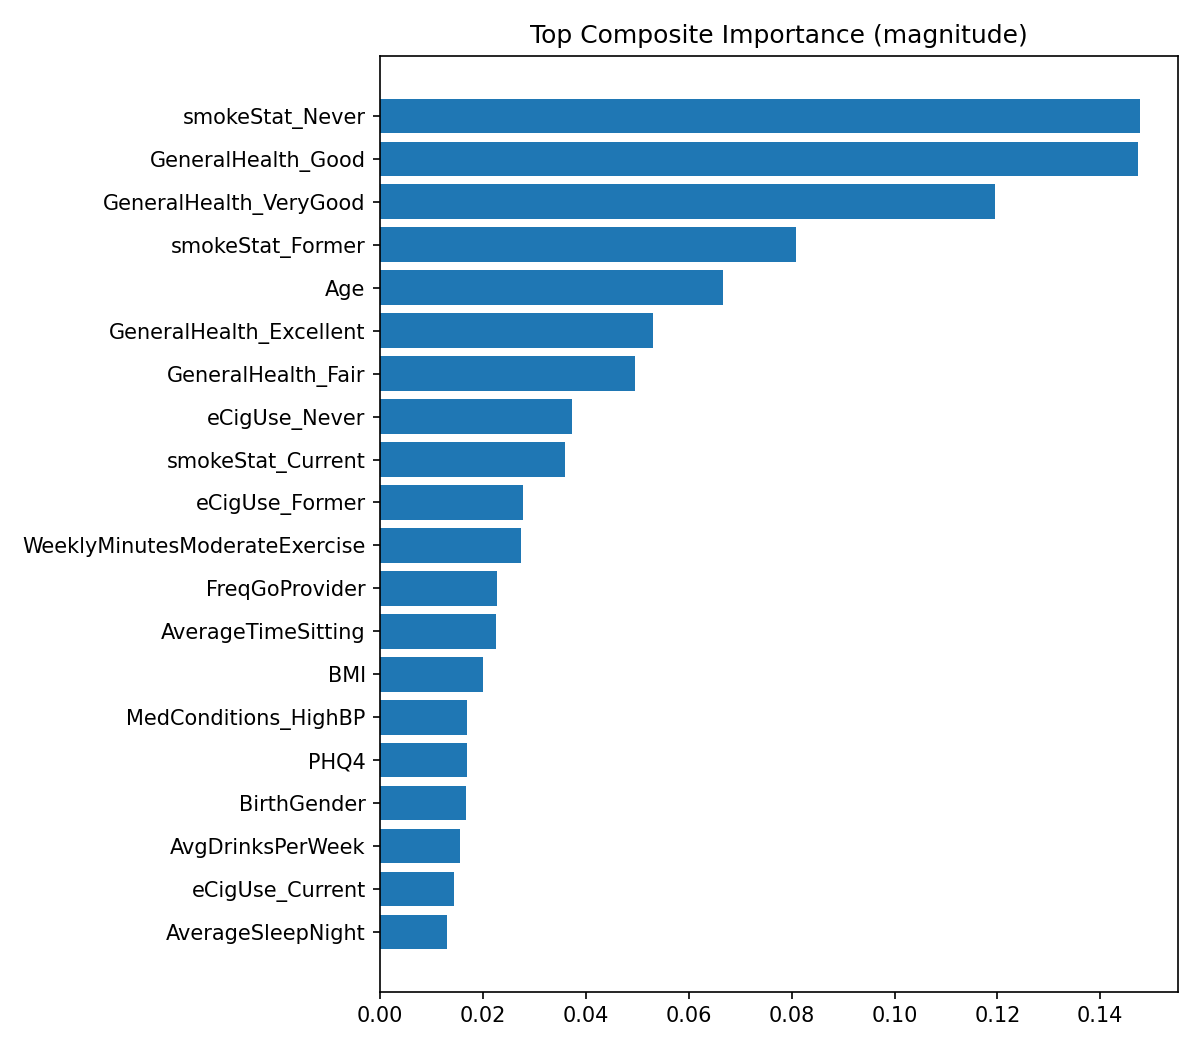

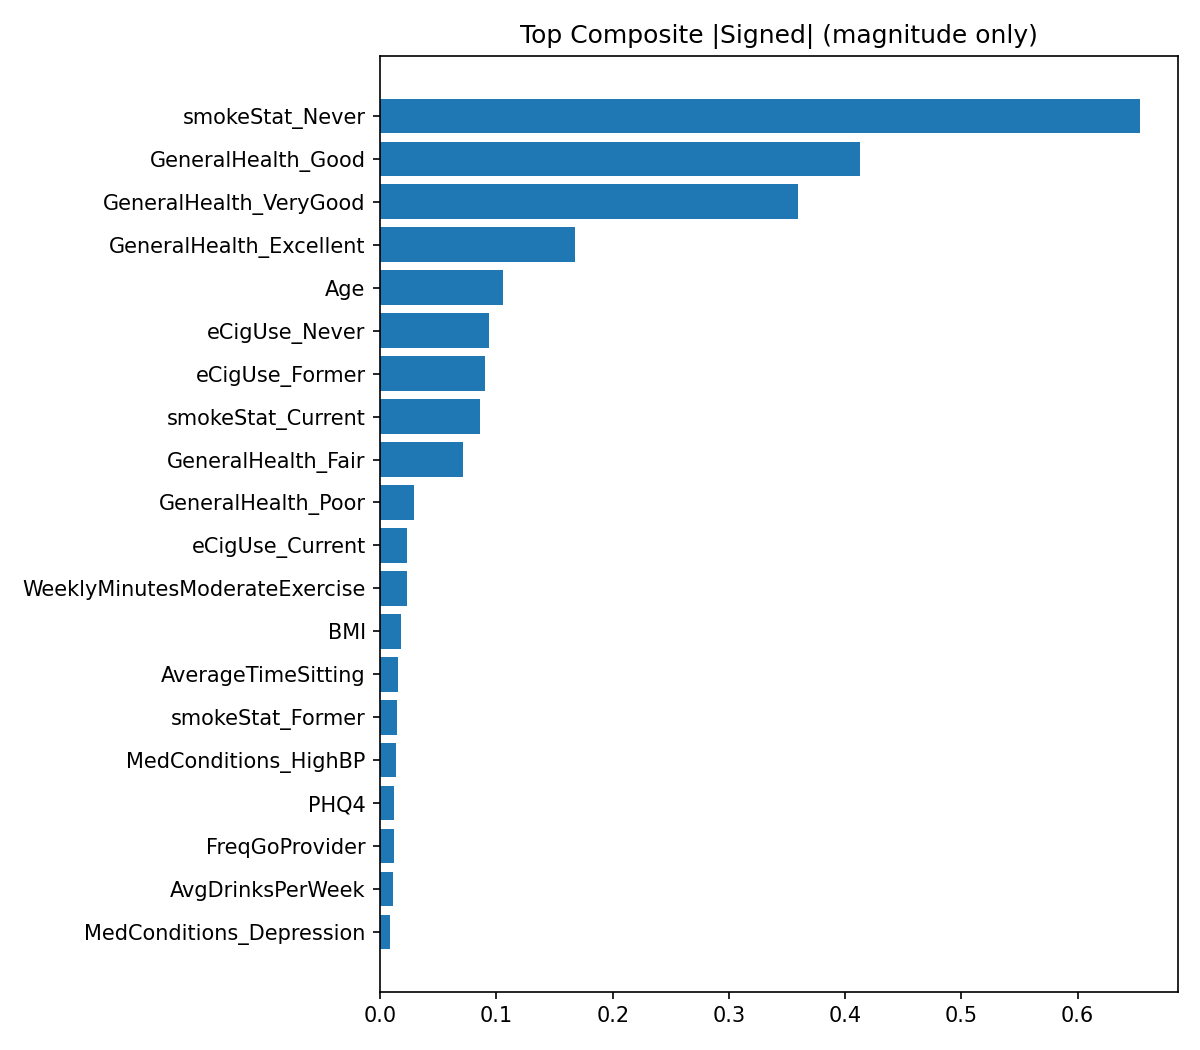

In [32]:
# show top-N composite importance on screen
plot_topn(comp_df["CompositeImportance"],
          "Top Composite Importance (magnitude)",
          outpath=os.path.join(OUTDIR, "top_composite_importance.png"),
          topn=TOPN_PLOT)

plot_topn(comp_df["CompositeSigned"].abs(),
          "Top Composite |Signed| (magnitude only)",
          outpath=os.path.join(OUTDIR, "top_composite_signed_abs.png"),
          topn=TOPN_PLOT)

# display inline in the notebook
from IPython.display import Image, display
display(Image(filename=os.path.join(OUTDIR, "top_composite_importance.png")))
display(Image(filename=os.path.join(OUTDIR, "top_composite_signed_abs.png")))


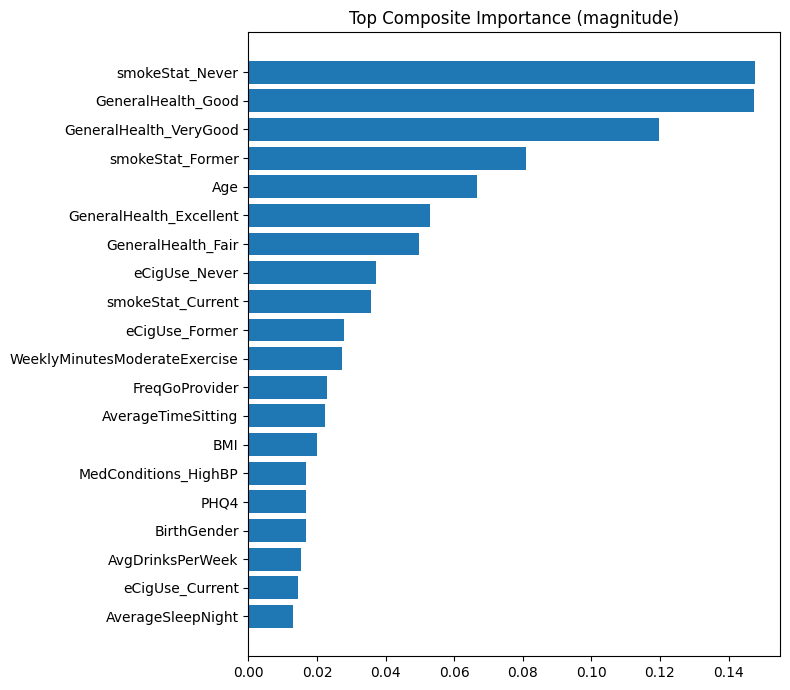

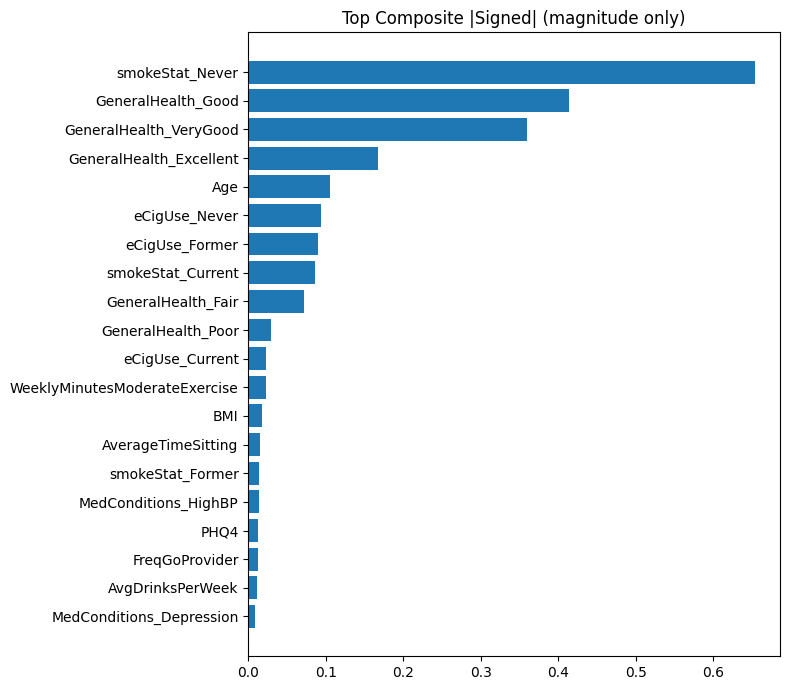

In [41]:
import os
import pandas as pd
import matplotlib.pyplot as plt

OUTDIR = "op/1_data_explore3/exports_preproc_dataset/composite_fast_20251002_221250"   # e.g., "op/1_data_explore3/exports_preproc_dataset2025-10-02_1530"

# reload composite df
comp_df = pd.read_csv(os.path.join(OUTDIR, "composite_importance.csv"), index_col=0)

def plot_topn(series, title, outpath, topn=20):
    s = series.sort_values(ascending=False).head(topn)[::-1]
    plt.figure(figsize=(8, max(4, topn*0.35)))
    plt.barh(s.index, s.values)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.show()
    plt.close()

# make & show both plots
plot_topn(comp_df["CompositeImportance"], "Top Composite Importance (magnitude)",
          os.path.join(OUTDIR, "top_composite_importance.png"), topn=20)

plot_topn(comp_df["CompositeSigned"].abs(), "Top Composite |Signed| (magnitude only)",
          os.path.join(OUTDIR, "top_composite_signed_abs.png"), topn=20)


In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_comparative_importance(imp_mag: dict,
                                comp_df: pd.DataFrame,
                                outdir: str,
                                topn: int = 20,
                                title_suffix: str = "(mean |SHAP|)"):
    """
    Creates two plots:
      1) Grouped horizontal bars comparing each model's mean |SHAP| and the Composite per feature
      2) A (column-wise) min-max normalized heatmap for quick visual comparison

    Expects:
      - imp_mag: dict like {'lr': Series, 'rf': Series, ...} with index=feature names, values=mean |SHAP|
      - comp_df: DataFrame with a column 'CompositeImportance'
    """
    os.makedirs(outdir, exist_ok=True)

    # --- Assemble a single table: all models + composite ---
    imps_df = pd.DataFrame(imp_mag).copy()  # each column = a model
    # ensure composite is present
    if "CompositeImportance" not in comp_df.columns:
        raise ValueError("comp_df must include 'CompositeImportance'")

    imps_df["Composite"] = comp_df["CompositeImportance"]

    # Keep only features present in at least one column (drop all-NaN rows)
    imps_df = imps_df.dropna(how="all")

    # Order by Composite and take top-N
    order = imps_df["Composite"].sort_values(ascending=False).head(topn).index
    sub = imps_df.loc[order]

    # Column order: put Composite last in legend for emphasis (or first if you prefer)
    cols = [c for c in sub.columns if c != "Composite"] + ["Composite"]
    sub = sub[cols]

    # ========== 1) Grouped horizontal bars ==========
    n_feat = len(sub)
    n_cols = len(cols)
    base_y = np.arange(n_feat)

    # spacing
    total_height = 0.8
    bar_h = total_height / n_cols
    offsets = (np.arange(n_cols) - (n_cols - 1) / 2.0) * bar_h

    plt.figure(figsize=(10, max(4, int(topn * 0.45))))
    for i, col in enumerate(cols):
        y = base_y + offsets[i]
        vals = sub[col].values
        plt.barh(y, vals, height=bar_h, label=col)

        # value labels (small, to the right)
        for yy, vv in zip(y, vals):
            if np.isfinite(vv) and vv != 0:
                plt.text(vv, yy, f"{vv:.3f}", va="center", ha="left", fontsize=8)

    plt.gca().set_yticks(base_y)
    plt.gca().set_yticklabels(sub.index)
    plt.gca().invert_yaxis()  # highest at top
    plt.xlabel("Mean |SHAP|")
    plt.title(f"Top {topn} Features — Comparative Importance {title_suffix}")
    plt.legend(ncol=min(3, n_cols), fontsize=9)
    plt.tight_layout()

    outpath_grouped = os.path.join(outdir, f"comparative_importance_grouped_top{topn}.png")
    plt.savefig(outpath_grouped, dpi=150)
    plt.close()

    # ========== 2) Heatmap (column-wise min–max) ==========
    # Normalize each column to [0,1] to compare patterns
    norm = sub.copy()
    for c in cols:
        col = norm[c].astype(float)
        rng = col.max() - col.min()
        if pd.isna(rng) or rng == 0:
            norm[c] = 0.0  # flat column
        else:
            norm[c] = (col - col.min()) / rng

    fig = plt.figure(figsize=(max(7, 0.45 * n_cols + 6), max(4, 0.45 * n_feat + 2)))
    ax = plt.gca()
    im = ax.imshow(norm.values, aspect="auto", interpolation="nearest")
    ax.set_yticks(np.arange(n_feat))
    ax.set_yticklabels(norm.index)
    ax.set_xticks(np.arange(n_cols))
    ax.set_xticklabels(cols, rotation=45, ha="right")
    ax.set_title(f"Top {topn} Features — Normalized Comparative Importance {title_suffix}")
    plt.colorbar(im, ax=ax, label="Column-wise min–max scaled")
    plt.tight_layout()

    outpath_heat = os.path.join(outdir, f"comparative_importance_heatmap_top{topn}.png")
    plt.savefig(outpath_heat, dpi=150)
    plt.close()

    print(f"[OK] Saved:\n- {outpath_grouped}\n- {outpath_heat}")

# ---- run it ----
TOPN = 20  # adjust as you like
plot_comparative_importance(imp_mag=imp_mag, comp_df=comp_df, outdir=OUTDIR, topn=TOPN)


[OK] Saved:
- op/1_data_explore3/exports_preproc_dataset/composite_fast_20251002_221250/comparative_importance_grouped_top20.png
- op/1_data_explore3/exports_preproc_dataset/composite_fast_20251002_221250/comparative_importance_heatmap_top20.png


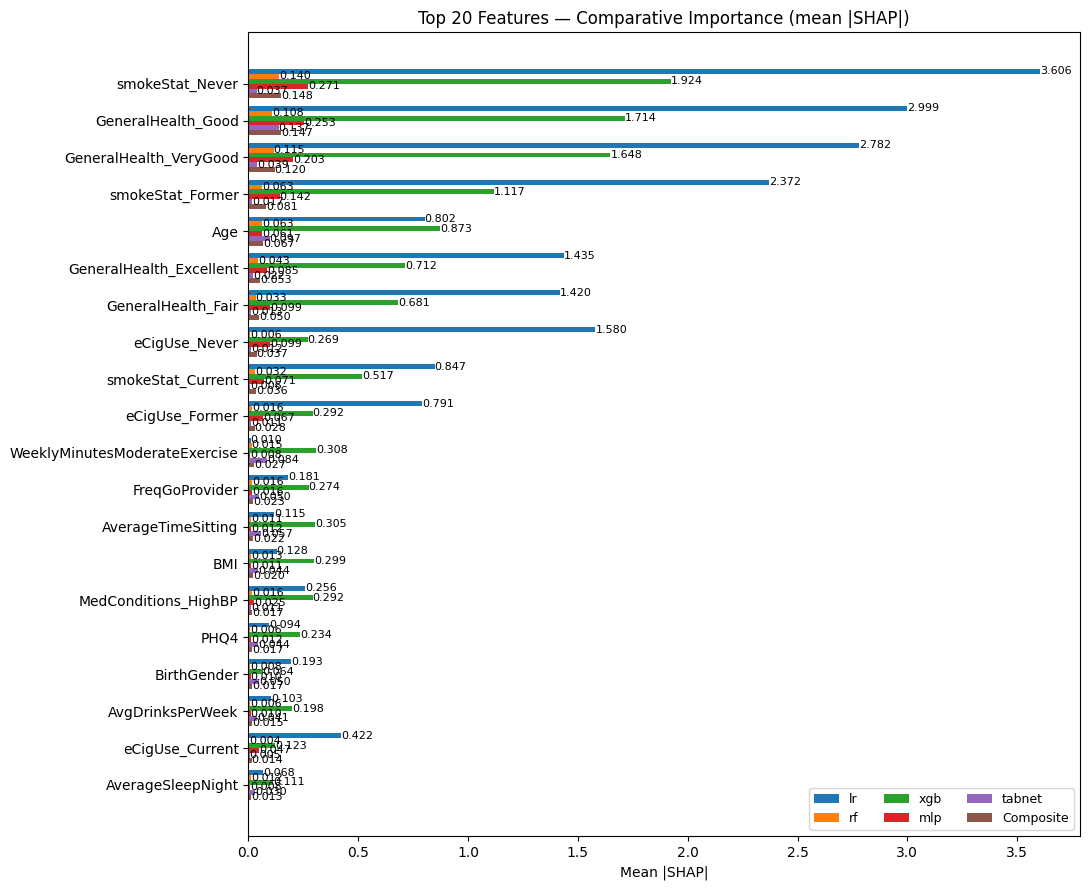

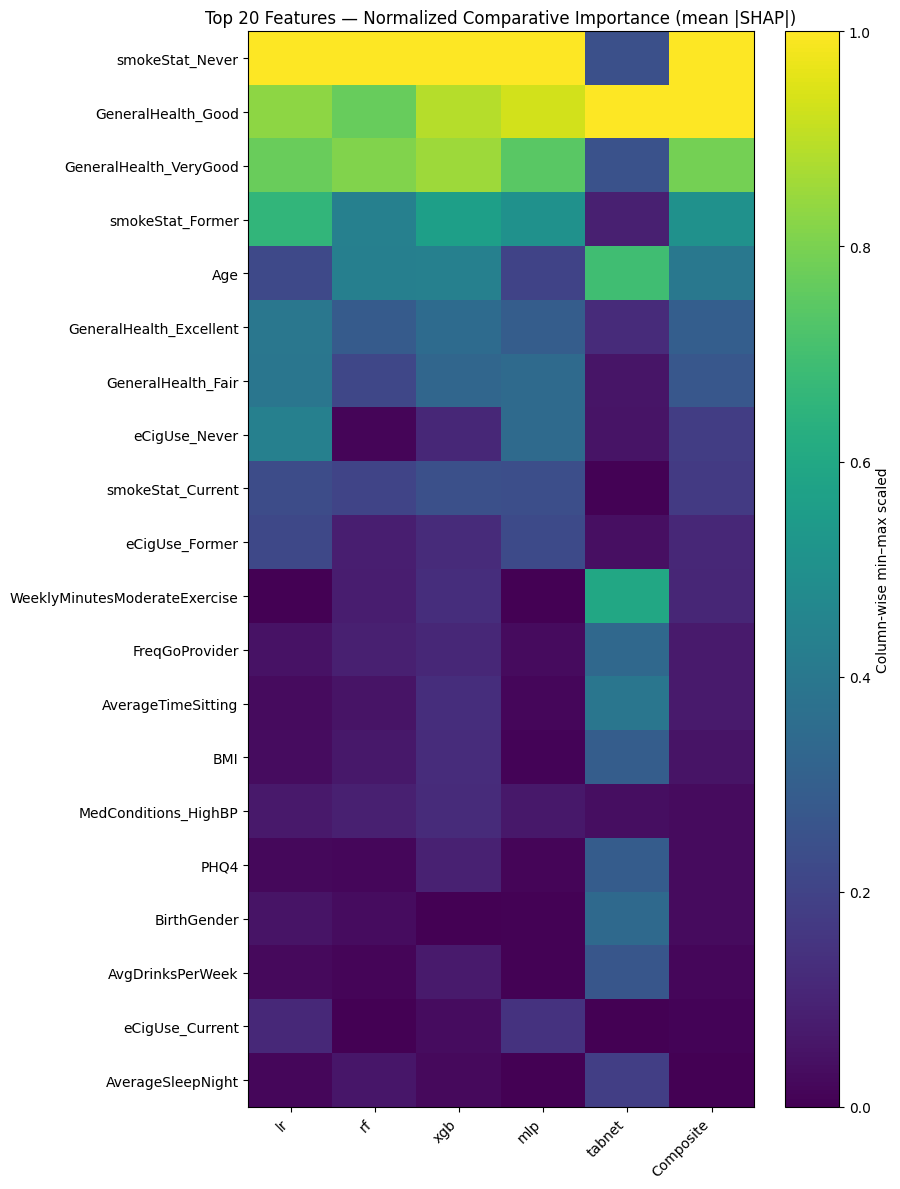

Saved:
- op/1_data_explore3/exports_preproc_dataset/composite_fast_20251002_221250/comparative_importance_grouped_top20.png
- op/1_data_explore3/exports_preproc_dataset/composite_fast_20251002_221250/comparative_importance_heatmap_top20.png


In [44]:
# ======= CONFIG =======
OUTDIR = "op/1_data_explore3/exports_preproc_dataset/composite_fast_20251002_221250"
TOPN   = 20
XLSX_MASTER = "/mnt/data/ColFilteredDataFile.xlsx"  # has alias + tabnet column
# ======================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- load exports ----------
comp_path = os.path.join(OUTDIR, "composite_importance.csv")
per_model_path = os.path.join(OUTDIR, "per_model_mean_abs_shap.csv")

comp_df = pd.read_csv(comp_path, index_col=0)
per_model_mag = pd.read_csv(per_model_path, index_col=0)
per_model_mag.columns = [str(c) for c in per_model_mag.columns]  # normalize names

# ---------- ensure TabNet column exists ----------
def _find_tabnet_col(df_cols):
    for c in df_cols:
        if "tabnet" in c.lower():
            return c
    return None

tab_col = _find_tabnet_col(per_model_mag.columns)

if tab_col is None:
    # try to pull from the master Excel by aligning on 'alias'
    if not os.path.exists(XLSX_MASTER):
        raise FileNotFoundError(f"TabNet missing in CSVs and Excel not found at {XLSX_MASTER}")

    xdf = pd.read_excel(XLSX_MASTER)

    # Guess the feature-name column (prefer 'alias')
    feat_col = "alias" if "alias" in xdf.columns else None
    if feat_col is None:
        # heuristics: pick the first string-ish column with many uniques
        str_cols = [c for c in xdf.columns if xdf[c].dtype == "object"]
        feat_col = str_cols[0] if str_cols else xdf.columns[0]

    # find a reasonable TabNet column
    cand_cols = [c for c in xdf.columns if ("tabnet" in c.lower() and "mean" in c.lower())]
    if not cand_cols and "mean_abs_shap_tabnet" in xdf.columns:
        cand_cols = ["mean_abs_shap_tabnet"]
    if not cand_cols:
        raise KeyError("Could not find a TabNet mean |SHAP| column in the Excel. "
                       "Looked for names containing 'tabnet' and 'mean' or 'mean_abs_shap_tabnet'.")

    tn_series = (
        xdf[[feat_col, cand_cols[0]]]
        .dropna()
        .set_index(feat_col)[cand_cols[0]]
        .astype(float)
        .rename("tabnet")
    )

    # align to per_model index; add as 'tabnet'
    per_model_mag["tabnet"] = tn_series.reindex(per_model_mag.index)
    tab_col = "tabnet"

# ---------- combine with Composite ----------
# try to find composite column name
comp_col = "CompositeImportance"
if comp_col not in comp_df.columns:
    for c in comp_df.columns:
        if c.lower().startswith("composite"):
            comp_col = c
            break

imps_df = per_model_mag.copy()
imps_df["Composite"] = comp_df[comp_col]
imps_df = imps_df.dropna(how="all")

# ---------- pick top-N by Composite ----------
order = imps_df["Composite"].sort_values(ascending=False).head(TOPN).index
sub = imps_df.loc[order]

# Put Composite at the end of the legend (feel free to change)
cols = [c for c in sub.columns if c != "Composite"] + ["Composite"]
sub = sub[cols]

# ---------- 1) Grouped horizontal bars ----------
n_feat = len(sub)
n_cols = len(cols)
base_y = np.arange(n_feat)

total_height = 0.8
bar_h = total_height / n_cols
offsets = (np.arange(n_cols) - (n_cols - 1) / 2.0) * bar_h

plt.figure(figsize=(11, max(4, int(TOPN * 0.48))))
for i, col in enumerate(cols):
    y = base_y + offsets[i]
    vals = sub[col].values
    plt.barh(y, vals, height=bar_h, label=col)
    # small value labels
    for yy, vv in zip(y, vals):
        if np.isfinite(vv) and vv != 0:
            plt.text(vv, yy, f"{vv:.3f}", va="center", ha="left", fontsize=8)

plt.gca().set_yticks(base_y)
plt.gca().set_yticklabels(sub.index)
plt.gca().invert_yaxis()
plt.xlabel("Mean |SHAP|")
plt.title(f"Top {TOPN} Features — Comparative Importance (mean |SHAP|)")
plt.legend(ncol=min(3, n_cols), fontsize=9)
plt.tight_layout()
plt.show()

# save grouped plot
grouped_path = os.path.join(OUTDIR, f"comparative_importance_grouped_top{TOPN}.png")
plt.figure(figsize=(11, max(4, int(TOPN * 0.48))))
for i, col in enumerate(cols):
    y = base_y + offsets[i]
    vals = sub[col].values
    plt.barh(y, vals, height=bar_h, label=col)
    for yy, vv in zip(y, vals):
        if np.isfinite(vv) and vv != 0:
            plt.text(vv, yy, f"{vv:.3f}", va="center", ha="left", fontsize=8)
plt.gca().set_yticks(base_y)
plt.gca().set_yticklabels(sub.index)
plt.gca().invert_yaxis()
plt.xlabel("Mean |SHAP|")
plt.title(f"Top {TOPN} Features — Comparative Importance (mean |SHAP|)")
plt.legend(ncol=min(3, n_cols), fontsize=9)
plt.tight_layout()
plt.savefig(grouped_path, dpi=150)
plt.close()

# ---------- 2) Heatmap (column-wise min–max) ----------
norm = sub.astype(float).copy()
for c in cols:
    col = norm[c]
    rng = col.max() - col.min()
    norm[c] = 0.0 if (pd.isna(rng) or rng == 0) else (col - col.min()) / rng

fig = plt.figure(figsize=(max(8, 0.5 * n_cols + 6), max(4, 0.5 * n_feat + 2)))
ax = plt.gca()
im = ax.imshow(norm.values, aspect="auto", interpolation="nearest")
ax.set_yticks(np.arange(n_feat))
ax.set_yticklabels(norm.index)
ax.set_xticks(np.arange(n_cols))
ax.set_xticklabels(cols, rotation=45, ha="right")
ax.set_title(f"Top {TOPN} Features — Normalized Comparative Importance (mean |SHAP|)")
plt.colorbar(im, ax=ax, label="Column-wise min–max scaled")
plt.tight_layout()
plt.show()

# save heatmap
heatmap_path = os.path.join(OUTDIR, f"comparative_importance_heatmap_top{TOPN}.png")
fig = plt.figure(figsize=(max(8, 0.5 * n_cols + 6), max(4, 0.5 * n_feat + 2)))
ax = plt.gca()
im = ax.imshow(norm.values, aspect="auto", interpolation="nearest")
ax.set_yticks(np.arange(n_feat))
ax.set_yticklabels(norm.index)
ax.set_xticks(np.arange(n_cols))
ax.set_xticklabels(cols, rotation=45, ha="right")
ax.set_title(f"Top {TOPN} Features — Normalized Comparative Importance (mean |SHAP|)")
plt.colorbar(im, ax=ax, label="Column-wise min–max scaled")
plt.tight_layout()
plt.savefig(heatmap_path, dpi=150)
plt.close()

print("Saved:")
print(f"- {grouped_path}")
print(f"- {heatmap_path}")


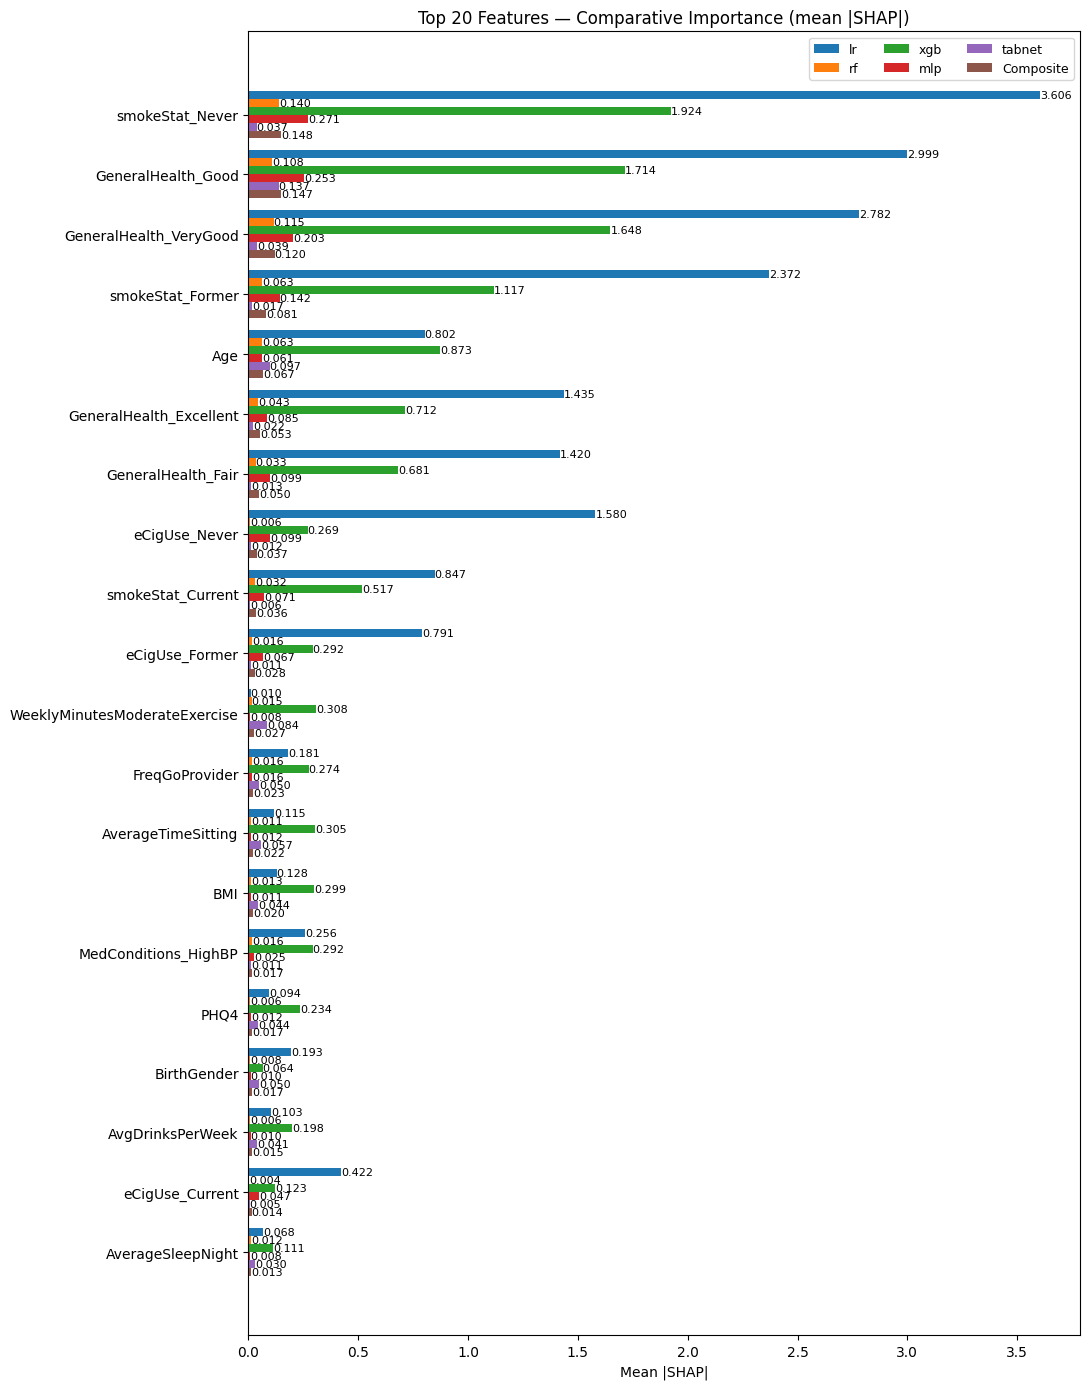

In [45]:
# ---------- 1) Grouped horizontal bars (3× thicker) ----------
n_feat = len(sub)
n_cols = len(cols)

bar_thickness_factor = 3.0  # <-- 3x thicker

# scale the y spacing AND the bar heights so bars don't collide
base_y = np.arange(n_feat) * bar_thickness_factor
total_height = 0.8 * bar_thickness_factor
bar_h = total_height / n_cols
offsets = (np.arange(n_cols) - (n_cols - 1) / 2.0) * bar_h

plt.figure(figsize=(11, max(4, int(TOPN * 0.48 * bar_thickness_factor/2))))
for i, col in enumerate(cols):
    y = base_y + offsets[i]
    vals = sub[col].values
    plt.barh(y, vals, height=bar_h, label=col)
    for yy, vv in zip(y, vals):
        if np.isfinite(vv) and vv != 0:
            plt.text(vv, yy, f"{vv:.3f}", va="center", ha="left", fontsize=8)

plt.gca().set_yticks(base_y)
plt.gca().set_yticklabels(sub.index)
plt.gca().invert_yaxis()
plt.xlabel("Mean |SHAP|")
plt.title(f"Top {TOPN} Features — Comparative Importance (mean |SHAP|)")
plt.legend(ncol=min(3, len(cols)), fontsize=9)
plt.tight_layout()
plt.show()

# (optional) when saving, reuse the same geometry
grouped_path = os.path.join(OUTDIR, f"comparative_importance_grouped_top{TOPN}_thick.png")
plt.figure(figsize=(11, max(4, int(TOPN * 0.48 * bar_thickness_factor/2))))
for i, col in enumerate(cols):
    y = base_y + offsets[i]
    vals = sub[col].values
    plt.barh(y, vals, height=bar_h, label=col)
    for yy, vv in zip(y, vals):
        if np.isfinite(vv) and vv != 0:
            plt.text(vv, yy, f"{vv:.3f}", va="center", ha="left", fontsize=8)
plt.gca().set_yticks(base_y)
plt.gca().set_yticklabels(sub.index)
plt.gca().invert_yaxis()
plt.xlabel("Mean |SHAP|")
plt.title(f"Top {TOPN} Features — Comparative Importance (mean |SHAP|)")
plt.legend(ncol=min(3, len(cols)), fontsize=9)
plt.tight_layout()
plt.savefig(grouped_path, dpi=150)
plt.close()


In [48]:
import os, re, numpy as np, pandas as pd
from sklearn.metrics import average_precision_score, roc_auc_score
from math import exp

# ---- CONFIG ----
OUTDIR = "op/1_data_explore3/exports_preproc_dataset/composite_20251001_132655"
VAL_METRICS_CSV = os.path.join(OUTDIR, "validation_metrics_for_weights.csv")
METRIC_PREF = "prauc"   # prefer PR-AUC for imbalance; options: "prauc" or "rocauc"
# ----------------

# 1) Collect available models from your namespace
candidates = {}
for name in ["lr","rf","xgb","mlp","tabnet","stack","ensemble","best_model"]:
    if name in globals():
        candidates[name] = globals()[name]

if not candidates:
    raise RuntimeError("No candidate models found in globals(). Define one like: ref_model = xgb")

# 2) Read validation metrics and pick best model name
def find_col(df, regex_list):
    for r in regex_list:
        cols = [c for c in df.columns if re.search(r, c, flags=re.I)]
        if cols:
            return cols[0]
    return None

def pick_best_model_name(df):
    # Try to find model column
    model_col = find_col(df, [r"^model$", r"model_name", r"estimator", r"name"])
    if model_col is None:
        # heuristic: first object-like/string column
        obj_cols = [c for c in df.columns if df[c].dtype == "object"]
        model_col = obj_cols[0] if obj_cols else df.columns[0]

    # Candidate metric columns
    pr_col  = find_col(df, [r"^(ap|pr[_\- ]?auc)$", r"average[_\- ]?precision", r"pr.*auc"])
    roc_col = find_col(df, [r"^roc[_\- ]?auc$", r"auc(?!pr)", r"roc.*auc"])

    score_col = pr_col if (METRIC_PREF=="prauc" and pr_col) else (roc_col or pr_col)
    if score_col is None:
        # fallback: any numeric column with 'auc' in name
        aucish = [c for c in df.columns if re.search("auc", c, flags=re.I) and np.issubdtype(df[c].dtype, np.number)]
        score_col = aucish[0] if aucish else None
    if score_col is None:
        raise RuntimeError("Could not locate a validation metric column in the CSV.")

    # pick best row among models we actually have in memory
    df2 = df.copy()
    df2[model_col] = df2[model_col].astype(str).str.lower()
    present = [m.lower() for m in candidates.keys()]
    df2 = df2[df2[model_col].isin(present)]
    if df2.empty:
        # no names match; fall back to a simple priority order
        for pref in ["xgb","rf","lr","mlp","tabnet"]:
            if pref in candidates:
                return pref
        return list(candidates.keys())[0]

    best_row = df2.sort_values(score_col, ascending=False).iloc[0]
    return best_row[model_col]

# try loading the CSV; if not available, fall back to priority
if os.path.exists(VAL_METRICS_CSV):
    perf_df = pd.read_csv(VAL_METRICS_CSV)
    best_name = pick_best_model_name(perf_df)
else:
    best_name = next((m for m in ["xgb","rf","lr","mlp","tabnet"] if m in candidates), list(candidates.keys())[0])

ref_model = candidates[best_name]
print(f"[info] Using reference model for faithfulness test: {best_name}")

# 3) Safe proba function
def proba_fn(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:,1]
    elif hasattr(model, "decision_function"):
        # logistic link for margin -> probability
        z = model.decision_function(X)
        # numerically stable sigmoid
        return 1.0 / (1.0 + np.exp(-z))
    else:
        # last-ditch: use hard predictions as pseudo-proba
        return model.predict(X).astype(float)

# 4) Choose metric
def metric(y_true, y_prob):
    return average_precision_score(y_true, y_prob) if METRIC_PREF=="prauc" else roc_auc_score(y_true, y_prob)

# 5) Permutation-drop computation
yhat_base = proba_fn(ref_model, X_val)

def permutation_drop(X, y, model, feat):
    Xp = X.copy()
    Xp[feat] = np.random.permutation(Xp[feat].values)
    yhat_p = proba_fn(model, Xp)
    return metric(y, yhat_base) - metric(y, yhat_p)

# ---- run the faithfulness correlation for each method, including Composite ----
from scipy.stats import spearmanr

# imp_mag: dict of Series (mean |SHAP|) you already computed per model
# comp_df["CompositeImportance"]: Series with composite scores
drops = {f: permutation_drop(X_val, y_val, ref_model, f) for f in X_val.columns}
drop_s = pd.Series(drops)

def corr_vs_drop(series):
    s = series.reindex(drop_s.index).fillna(0)
    rho, p = spearmanr(s.values, drop_s.values)
    return rho, p

results_faith = {}
for m, ser in imp_mag.items():
    results_faith[m] = corr_vs_drop(ser)
results_faith["Composite"] = corr_vs_drop(comp_df["CompositeImportance"])

print("Spearman ρ with permutation-drop (higher is better):")
for k,(rho,p) in results_faith.items():
    print(f"{k:>10}: ρ={rho:.3f}, p={p:.3g}")


[info] Using reference model for faithfulness test: lr
Spearman ρ with permutation-drop (higher is better):
        lr: ρ=-0.120, p=0.559
        rf: ρ=-0.130, p=0.528
       xgb: ρ=-0.165, p=0.422
       mlp: ρ=-0.071, p=0.73
    tabnet: ρ=-0.017, p=0.933
 Composite: ρ=-0.121, p=0.557


In [49]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import average_precision_score, roc_auc_score

# ==== CONFIG ====
METRIC = "prauc"   # "prauc" (recommended for imbalance) or "rocauc"
R = 10             # permutation repeats per feature to reduce noise
RANDOM_STATE = 0
rng = np.random.default_rng(RANDOM_STATE)

# ---- helpers ----
def proba_fn(model):
    if hasattr(model, "predict_proba"):
        return lambda X: model.predict_proba(X)[:,1]
    elif hasattr(model, "decision_function"):
        return lambda X: 1.0/(1.0 + np.exp(-model.decision_function(X)))
    else:
        return lambda X: model.predict(X).astype(float)

def metric_fn(y_true, y_prob):
    if METRIC.lower() == "prauc":
        return average_precision_score(y_true, y_prob)
    else:
        return roc_auc_score(y_true, y_prob)

def permutation_drop_model(model, X, y, features, repeats=R):
    """Return a Series of mean performance drop per feature for the given model."""
    p = proba_fn(model)
    base = metric_fn(y, p(X))
    drops = {}
    for f in features:
        vals = []
        for _ in range(repeats):
            Xp = X.copy()
            Xp[f] = rng.permutation(Xp[f].values)
            vals.append(base - metric_fn(y, p(Xp)))
        drops[f] = float(np.mean(vals))
    return pd.Series(drops)

def zscore(s):
    s = pd.Series(s).astype(float)
    mu, sd = s.mean(), s.std(ddof=0)
    return (s - mu) / (sd if sd > 0 else 1.0)

# ==== INPUTS YOU ALREADY HAVE ====
# X_val, y_val: evaluation set (DataFrame/Series)
# imp_mag: dict of per-model mean|SHAP| Series (index = feature names), e.g. {"lr": s_lr, "rf": s_rf, ...}
# comp_df["CompositeImportance"]: Series
# Trained model objects in variables: lr, rf, xgb, mlp, tabnet (as available).
# If you have a composite/stack model object, set it to `composite_model`; else we’ll reuse the best single model.

# map names -> models that exist
models = {}
for name in ["lr","rf","xgb","mlp","tabnet","composite_model","stack","ensemble"]:
    if name in globals():
        models[name if name!="composite_model" else "Composite"] = globals()[name]

# If no composite model object is present, we can evaluate Composite importances
# against your best available single model to keep it consistent with your ranking target.
if "Composite" not in models:
    for pref in ["xgb","rf","lr","mlp","tabnet"]:
        if pref in models:
            models["Composite"] = models[pref]; break

# Build a unified importance dict including Composite
rankers = {**imp_mag, "Composite": comp_df["CompositeImportance"]}

# Align the feature universe
all_feats = list(pd.Index(X_val.columns).intersection(pd.Index(rankers["Composite"].index)))
for k in list(rankers.keys()):
    rankers[k] = rankers[k].reindex(all_feats)

# ==== Compute model-specific permutation drops ====
drop_by_model = {}
for mname in rankers.keys():
    if mname in models:
        print(f"[perm-drop] computing drops for {mname} ...")
        drop_by_model[mname] = permutation_drop_model(models[mname], X_val, y_val, all_feats, repeats=R)
    else:
        # If a model’s object isn’t present (e.g., you have a ranker but no trained object),
        # fall back to the Composite or first available model
        fallback = models.get("Composite", next(iter(models.values())))
        print(f"[perm-drop] {mname} model object not found; using fallback {fallback.__class__.__name__}")
        drop_by_model[mname] = permutation_drop_model(fallback, X_val, y_val, all_feats, repeats=R)

# ==== Correlations: Pearson (z-scored) + Spearman ====
rows = []
for mname, s_imp in rankers.items():
    s_imp = s_imp.reindex(all_feats).fillna(0.0)
    s_drop = drop_by_model[mname].reindex(all_feats).fillna(0.0)

    # Z-score the importance to put on same scale (doesn't affect Spearman; does affect Pearson magnitude interpretability)
    s_imp_z = zscore(s_imp)

    # Pearson on z-scored importances
    r, p_r = pearsonr(s_imp_z.values, s_drop.values)
    # Spearman (rank-based, scale-invariant)
    rho, p_rho = spearmanr(s_imp.values, s_drop.values)

    rows.append({"method": mname, "pearson_r": r, "pearson_p": p_r, "spearman_rho": rho, "spearman_p": p_rho})

corr_df = pd.DataFrame(rows).sort_values("pearson_r", ascending=False)
print(corr_df)

# ==== (Optional) Bootstrap 95% CI for Pearson r ====
def bootstrap_corr_ci(x, y, B=2000, seed=0):
    rng = np.random.default_rng(seed)
    n = len(x)
    stats = []
    for _ in range(B):
        idx = rng.integers(0, n, n)
        stats.append(pearsonr(x[idx], y[idx])[0])
    lo, hi = np.percentile(stats, [2.5, 97.5])
    return np.mean(stats), (lo, hi)

print("\nPearson r bootstrap 95% CI (z-scored importances):")
for mname, s_imp in rankers.items():
    x = zscore(s_imp.reindex(all_feats).fillna(0.0)).values
    y = drop_by_model[mname].reindex(all_feats).fillna(0.0).values
    mean_r, (lo, hi) = bootstrap_corr_ci(x, y, B=1000, seed=RANDOM_STATE)
    print(f"{mname:>10}: r≈{mean_r:.3f}  CI[{lo:.3f}, {hi:.3f}]")


[perm-drop] computing drops for lr ...
[perm-drop] computing drops for rf ...
[perm-drop] computing drops for xgb ...
[perm-drop] computing drops for mlp ...
[perm-drop] tabnet model object not found; using fallback XGBClassifier
[perm-drop] computing drops for Composite ...
      method  pearson_r     pearson_p  spearman_rho  spearman_p
1         rf   0.804589  7.260596e-07      0.501538    0.009045
2        xgb   0.770699  4.094785e-06      0.579487    0.001920
5  Composite   0.768501  4.534939e-06      0.662222    0.000228
4     tabnet   0.334636  9.472760e-02      0.209573    0.304172
3        mlp   0.134354  5.128806e-01      0.215726    0.289864
0         lr  -0.016614  9.357982e-01      0.145983    0.476721

Pearson r bootstrap 95% CI (z-scored importances):
        lr: r≈-0.015  CI[-0.263, 0.302]
        rf: r≈0.807  CI[0.578, 0.931]
       xgb: r≈0.771  CI[0.570, 0.898]
       mlp: r≈0.126  CI[-0.157, 0.360]
    tabnet: r≈0.332  CI[-0.018, 0.609]
 Composite: r≈0.774  CI[0.584,

In [50]:
import numpy as np
from scipy.stats import pearsonr, spearmanr

rng = np.random.default_rng(0)

def zscore(v):
    v = np.asarray(v, float); return (v - v.mean()) / (v.std() if v.std()>0 else 1)

def bootstrap_diff_corr(x_a, x_b, y, B=5000, kind="pearson", seed=0):
    rng = np.random.default_rng(seed)
    x_a = np.asarray(x_a, float); x_b = np.asarray(x_b, float); y = np.asarray(y, float)
    n = len(y); diffs = []
    for _ in range(B):
        idx = rng.integers(0, n, n)
        if kind == "pearson":
            ra = pearsonr(zscore(x_a[idx]), y[idx])[0]
            rb = pearsonr(zscore(x_b[idx]), y[idx])[0]
        else:
            ra = spearmanr(x_a[idx], y[idx]).correlation
            rb = spearmanr(x_b[idx], y[idx]).correlation
        diffs.append(ra - rb)
    diffs = np.array(diffs)
    mean = diffs.mean()
    lo, hi = np.percentile(diffs, [2.5, 97.5])
    # two-sided p for mean!=0, via bootstrap sign test
    p = 2*min((diffs <= 0).mean(), (diffs >= 0).mean())
    return mean, (lo, hi), p

# Align vectors (use the exact ones you computed above)
feats = drop_by_model["Composite"].index
y_drop_comp = drop_by_model["Composite"].reindex(feats).values

x_comp = rankers["Composite"].reindex(feats).values
x_rf   = rankers["rf"].reindex(feats).values
x_xgb  = rankers["xgb"].reindex(feats).values

print("Composite vs RF (Pearson):", bootstrap_diff_corr(x_comp, x_rf,  y_drop_comp, kind="pearson"))
print("Composite vs XGB (Pearson):", bootstrap_diff_corr(x_comp, x_xgb, y_drop_comp, kind="pearson"))
print("Composite vs RF (Spearman):", bootstrap_diff_corr(x_comp, x_rf,  y_drop_comp, kind="spearman"))
print("Composite vs XGB (Spearman):", bootstrap_diff_corr(x_comp, x_xgb, y_drop_comp, kind="spearman"))


Composite vs RF (Pearson): (np.float64(-0.03871849477500732), (np.float64(-0.09261139166087319), np.float64(0.004166801592762391)), np.float64(0.0736))
Composite vs XGB (Pearson): (np.float64(-0.013083193680921852), (np.float64(-0.04444353090512946), np.float64(0.02240575028121644)), np.float64(0.408))
Composite vs RF (Spearman): (np.float64(0.026730125018292233), (np.float64(-0.08508818832436268), np.float64(0.1694842315321843)), np.float64(0.6756))
Composite vs XGB (Spearman): (np.float64(0.0653163743561882), (np.float64(-0.04636035997484785), np.float64(0.21495375642855635)), np.float64(0.2824))
